# **Audience** **Decode** **- Machine Learning Project**



This project explores how user behavior and movie characteristics can be leveraged to build a data-driven recommendation system.
Using a relational dataset (**viewer_interactions.db**) containing user ratings, aggregated user statistics, movie statistics, and movie metadata, the analysis focuses on both audience and content segmentation.
Users and movies are clustered independently using **K-Means**, **MiniBatch K-Means**, and **BIRCH**, following a targeted exploratory data analysis and careful preprocessing.
The clustering models are evaluated in terms of quality, balance, and computational efficiency.

The resulting segmentations are then combined into a user-cluster × movie-cluster preference matrix, which enables the analysis of structured affinities between different types of users and movies.

Overall, the project aims to decode audience preferences and behavioral patterns, providing an interpretable foundation for recommendation and strategic content insights.

# **0. SET UP & DATA LOADING**

In this section, we prepare the environment and load the dataset from the SQLite database. We import the libraries needed for data handling, visualization, and clustering, then connect to *viewer_interactions.db* to verify which tables are available. Finally, we read the main tables into Pandas DataFrames and print their shapes to confirm that the data has been loaded correctly before proceeding with EDA and modeling.

We first import the required packages and open a connection to the database. As a quick sanity check, we list the available tables to ensure the database structure matches what we expect (ratings, movies, and pre-computed statistics).

In [1]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans, Birch
from sklearn.decomposition import PCA

db_path = "viewer_interactions.db"

conn = sqlite3.connect(db_path)

# Show available tables
tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)
print("Tables in the database viewer_interactions"":")
for name in tables["name"]:
    print(name)

Tables in the database viewer_interactions:
viewer_ratings
movies
user_statistics
movie_statistics
data_dictionary


If the printed list includes the expected tables, we can proceed safely. This step helps avoid downstream errors due to missing tables, wrong database files, or naming mismatches.

Next, we load the main tables into DataFrames and check their dimensions. We expect *viewer_ratings* to be the largest table (interaction-level data), while the statistics tables should be more compact summaries.

In [2]:
viewer_ratings   = pd.read_sql("SELECT * FROM viewer_ratings;", conn)
movies           = pd.read_sql("SELECT * FROM movies;", conn)
user_statistics  = pd.read_sql("SELECT * FROM user_statistics;", conn)
movie_statistics = pd.read_sql("SELECT * FROM movie_statistics;", conn)
data_dictionary  = pd.read_sql("SELECT * FROM data_dictionary;", conn)

conn.close()

print("\nShapes of main tables:")
print("viewer_ratings  : ", viewer_ratings.shape)
print("movies          :", movies.shape)
print("user_statistics :", user_statistics.shape)
print("movie_statistics:", movie_statistics.shape)


Shapes of main tables:
viewer_ratings  :  (4025000, 5)
movies          : (18008, 3)
user_statistics : (438780, 10)
movie_statistics: (16015, 11)


The printed shapes confirm that the tables have been successfully loaded into memory. From this point on, the analysis, feature engineering, and clustering steps operate directly on these DataFrames.

# **1.1 EDA - USER STATISTICS**

This section explores the user_statistics table to describe user behavior in the dataset. We analyze engagement intensity (*total_ratings*), rating tendency (*avg_rating*), preference variability (*std_rating*), and temporal persistence (*activity_days*). Since user activity typically exhibits heavy-tailed behavior, we use log-scaled visualizations where appropriate. Finally, we inspect correlations among user-level features to identify partially redundant signals and motivate later feature choices for clustering.

We start with a quick structural check of the dataset and preview a few rows. This confirms the number of users and the availability of the expected summary features.

In [3]:
# 1.1.1 Dataset overview

print("User statistics dataset shape:", user_statistics.shape)
user_statistics.head()

User statistics dataset shape: (438780, 10)


,customer_id,total_ratings,avg_rating,std_rating,min_rating,max_rating,unique_movies,first_rating_date,last_rating_date,activity_days
0,1965326,8.0,3.250000,0.886405,2.0,5.0,8.0,2004-08-11,2005-06-06,299.0
1,506434,1.0,4.000000,NaN,4.0,4.0,1.0,2005-08-02,2005-08-02,0.0
2,1365167,3.0,4.666667,0.577350,4.0,5.0,3.0,2004-11-16,2005-01-19,64.0
3,396632,2.0,NaN,0.000000,4.0,4.0,2.0,2004-07-07,2004-07-07,0.0
4,260614,3.0,4.333333,0.577350,4.0,5.0,3.0,2004-03-02,2004-10-13,NaN


The dataset shape provides the total number of user profiles available for analysis, while the preview helps validate feature names and data types before plotting distributions.

We examine the distribution of *total_ratings*, which captures how actively each user interacts with the platform. We expect a strong right-skew (many low-activity users and a small set of heavy users), so we visualize both linear and log scales and include a boxplot to highlight outliers.

Mean: 9.287267807149489
Median: 4.0


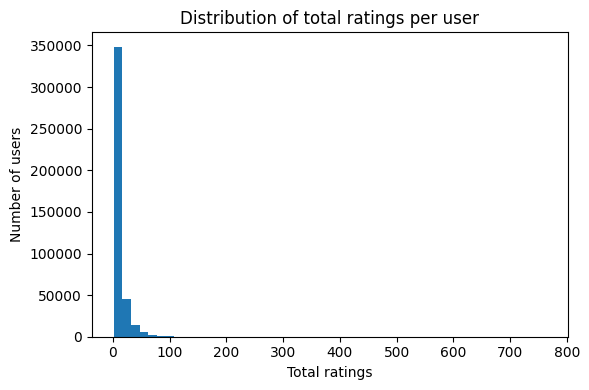

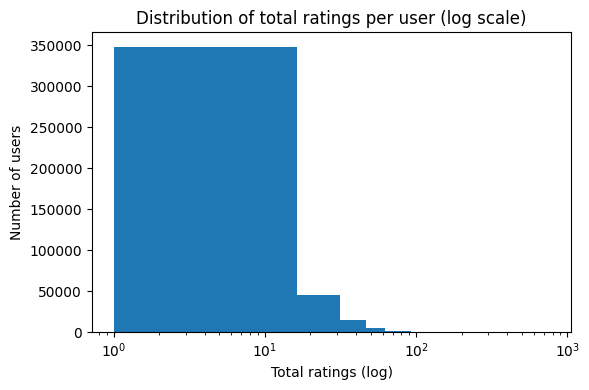

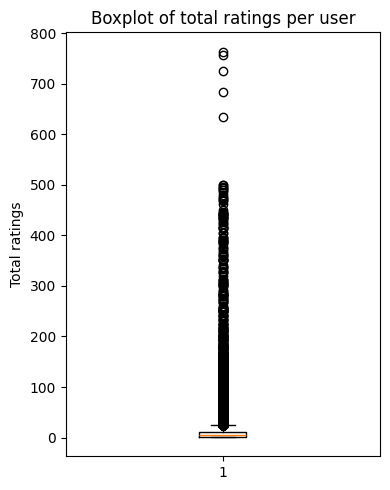

In [4]:
# UNIVARIATE DISTRIBUTIONS (USERS)
# 1.1.2 Distribution: total number of ratings per user

data = user_statistics["total_ratings"].dropna()

print("Mean:", data.mean())
print("Median:", data.median())

plt.figure(figsize=(6,4))
plt.hist(data, bins=50)
plt.title("Distribution of total ratings per user")
plt.xlabel("Total ratings")
plt.ylabel("Number of users")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.hist(data, bins=50)
plt.xscale("log")
plt.title("Distribution of total ratings per user (log scale)")
plt.xlabel("Total ratings (log)")
plt.ylabel("Number of users")
plt.tight_layout()
plt.show()

plt.figure(figsize=(4,5))
plt.boxplot(data, vert=True)
plt.title("Boxplot of total ratings per user")
plt.ylabel("Total ratings")
plt.tight_layout()
plt.show()

The distribution of total ratings per user is highly right-skewed: most users contribute only a few ratings, while a small minority is extremely active. This pattern is visible in the long tail (especially on the log-scale histogram) and in the boxplot outliers. The strong mean–median gap is consistent with typical recommender-system data and motivates the use of log scales and robust clustering features.

Next, we analyze *avg_rating*, which summarizes each user’s overall rating tendency. Compared to activity variables, we expect a tighter distribution, with potential outliers often driven by users with very few ratings.

Mean: 3.6321948158680644
Median: 3.6875


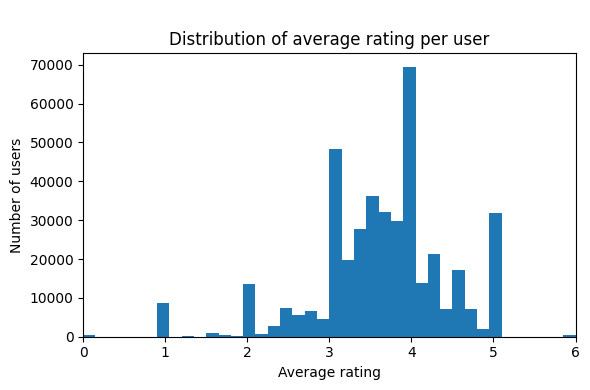

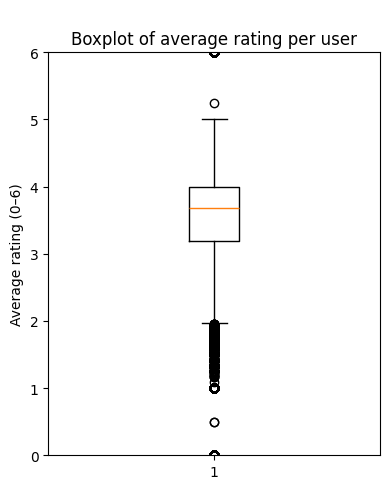

In [5]:
# 1.1.3 Distribution: average rating per user

data = user_statistics["avg_rating"].dropna()

print("Mean:", data.mean())
print("Median:", data.median())

plt.figure(figsize=(6,4))
plt.hist(data, bins=40, range=(0, 6))
plt.title("\nDistribution of average rating per user")
plt.xlabel("Average rating")
plt.ylabel("Number of users")
plt.xlim(0, 6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(4,5))
plt.boxplot(data, vert=True)
plt.title("\nBoxplot of average rating per user")
plt.ylabel("Average rating (0–6)")
plt.ylim(0, 6)
plt.tight_layout()
plt.show()

User average ratings are concentrated around mid-to-high values, with mean and median typically close, suggesting limited global rating bias. Compared to engagement features, this distribution is relatively compact, while the boxplot highlights a small number of extreme users (often explainable by low rating counts or unusually strict/lenient behavior).

We then consider *std_rating*, which measures how variable a user’s ratings are. This feature helps distinguish consistent raters from users whose evaluations fluctuate more strongly.

Mean: 0.8976237179922618
Median: 0.8677594571571442


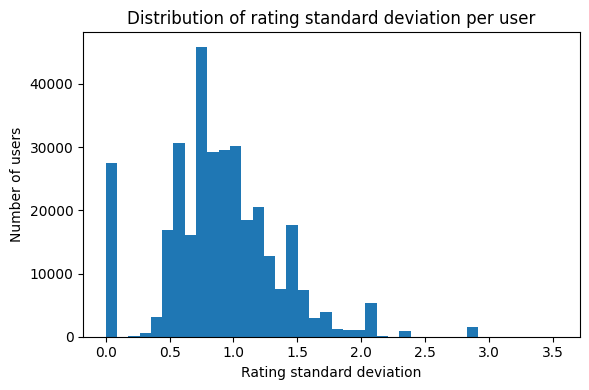

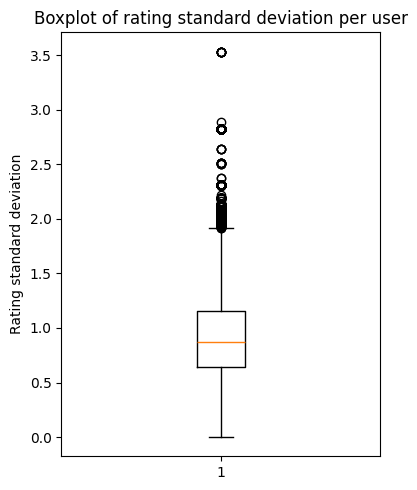

In [6]:
# 1.1.4 Distribution: standard deviation of ratings per user

data = user_statistics["std_rating"].dropna()

print("Mean:", data.mean())
print("Median:", data.median())

plt.figure(figsize=(6,4))
plt.hist(data, bins=40)
plt.title("Distribution of rating standard deviation per user")
plt.xlabel("Rating standard deviation")
plt.ylabel("Number of users")
plt.tight_layout()
plt.show()

plt.figure(figsize=(4,5))
plt.boxplot(data, vert=True)
plt.title("Boxplot of rating standard deviation per user")
plt.ylabel("Rating standard deviation")
plt.tight_layout()
plt.show()

Most users show moderate rating variability, indicating fairly consistent preferences. The right tail and boxplot outliers reveal a smaller group with highly volatile behavior, which can reflect eclectic tastes or sparsity effects (few ratings leading to unstable statistics).

Finally, we inspect *activity_days*, which approximates how long users remain active in the dataset. As with interaction counts, we expect a heavy-tailed distribution, so we again compare linear vs log-scale views and use a boxplot to emphasize extreme persistence.

Mean: 275.43724585633373
Median: 102.0


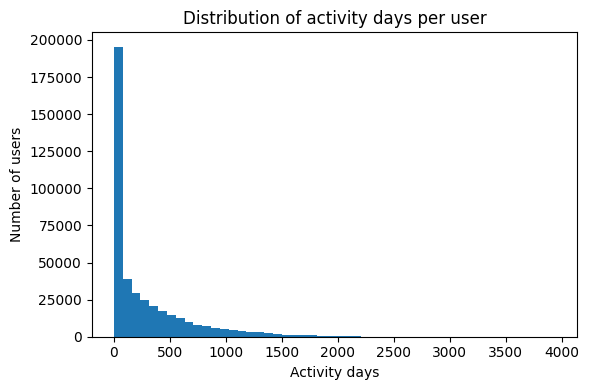

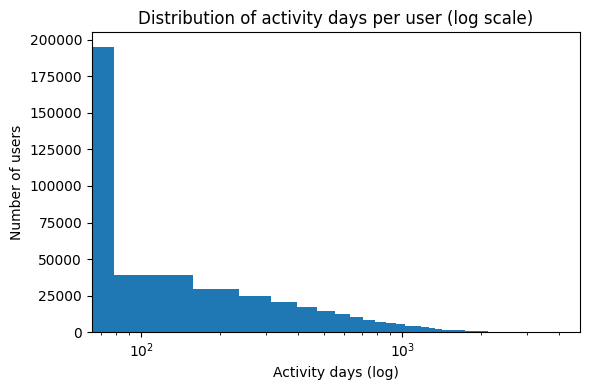

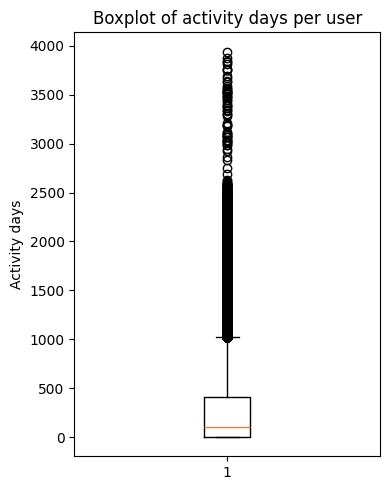

In [7]:
# 1.1.5 Distribution: activity (days) per user

data = user_statistics["activity_days"].dropna()

print("Mean:", data.mean())
print("Median:", data.median())

plt.figure(figsize=(6,4))
plt.hist(data, bins=50)
plt.title("Distribution of activity days per user")
plt.xlabel("Activity days")
plt.ylabel("Number of users")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.hist(data, bins=50)
plt.xscale("log")
plt.title("Distribution of activity days per user (log scale)")
plt.xlabel("Activity days (log)")
plt.ylabel("Number of users")
plt.tight_layout()
plt.show()

plt.figure(figsize=(4,5))
plt.boxplot(data, vert=True)
plt.title("Boxplot of activity days per user")
plt.ylabel("Activity days")
plt.tight_layout()
plt.show()

User activity spans a wide temporal range, again showing strong right-skew. Most users are active for relatively short periods, while a smaller set remains engaged over much longer time windows, visible in both the log-scale histogram and the boxplot extremes. This indicates substantial heterogeneity in user persistence, which can meaningfully affect clustering.

To detect redundancy and guide feature selection, we compute correlations among the main user features. We expect activity-related variables (e.g., *total_ratings*, *unique_movies*, *activity_days*) to be positively correlated, while rating tendency/variability (*avg_rating*, *std_rating*) should be more independent.

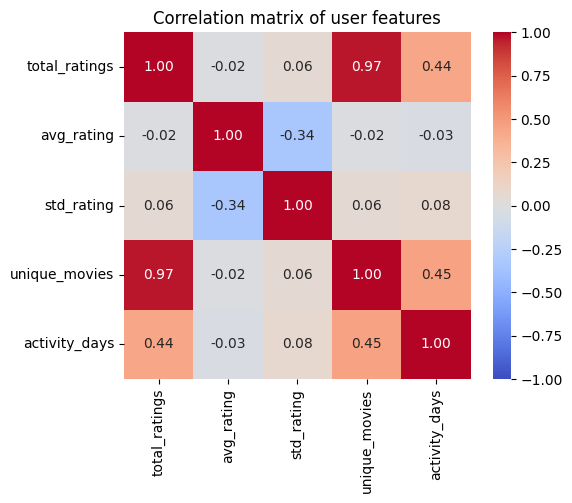

In [8]:
# 1.1.6 Correlation heatmap between user features (detect redundancy)

user_corr_cols = [
    "total_ratings",
    "avg_rating",
    "std_rating",
    "unique_movies",
    "activity_days"
]

user_corr_cols = [c for c in user_corr_cols if c in user_statistics.columns]

corr_users = user_statistics[user_corr_cols].corr()

plt.figure(figsize=(6,5))
sns.heatmap(
    corr_users,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    square=True
)
plt.title("Correlation matrix of user features")
plt.tight_layout()
plt.show()

Strong correlations typically emerge among activity-related features — especially between *total_ratings* and *unique_movies* — confirming partial redundancy in how engagement is measured. In contrast, *avg_rating* and std_rating tend to correlate weakly with activity variables, meaning rating behavior and rating volume capture complementary user traits. For clustering and interpretation, retaining both activity and preference-related features helps differentiate users beyond simple engagement levels.

# **1.2 EDA - MOVIE STATISTICS**

This section explores the *movie_statistics* table to characterize item-level behavior in the dataset. We focus on popularity signals (*total_ratings*, *unique_users*), perceived quality (*avg_rating*), and rating dispersion (*std_rating*). Since movie popularity typically follows a long-tail distribution, we use log-scaled visualizations where appropriate. We also inspect the relationship between popularity and quality via a scatter plot, and we conclude with a correlation heatmap to identify overlapping (potentially redundant) movie-level features.

We begin with a structural check and a preview of the table. This confirms the number of movies covered by the summary statistics and validates the presence of the features used in the following plots.

In [9]:
# 1.2.1 Quick overview (shape, head)

print("Movie statistics dataset shape:", movie_statistics.shape)
movie_statistics.head()


Movie statistics dataset shape: (16015, 11)


,movie_id,total_ratings,avg_rating,std_rating,min_rating,max_rating,unique_users,first_rating_date,last_rating_date,year_of_release,title
0,1,548.0,3.744526,1.073389,1.0,5.0,548.0,2003-07-12,2005-12-30,2003.0,Dinosaur Planet
1,2,146.0,3.547945,1.281606,1.0,5.0,146.0,2004-10-16,2005-12-20,2004.0,Isle of Man TT 2004 Review
2,3,2013.0,3.639841,0.978873,1.0,5.0,2013.0,2000-10-19,2005-12-30,1997.0,Character
3,4,142.0,2.739437,1.302913,1.0,5.0,142.0,2003-12-06,2005-12-27,1994.0,Paula Abdul's Get Up & Dance
4,5,1140.0,3.919298,1.292436,1.0,5.0,1140.0,2004-11-02,2005-12-29,2004.0,The Rise and Fall of ECW


The dataset shape provides the number of item profiles available for the analysis. The preview step helps verify that the key fields (popularity, average rating, and dispersion) are correctly loaded and ready for exploration.

We first analyze *total_ratings*, which measures overall movie popularity. We expect a highly right-skewed distribution (many movies with few ratings and a small set with very large exposure), so we visualize both linear and log scales and include a boxplot to highlight outliers.

Mean: 260.04416694051923
Median: 1.0


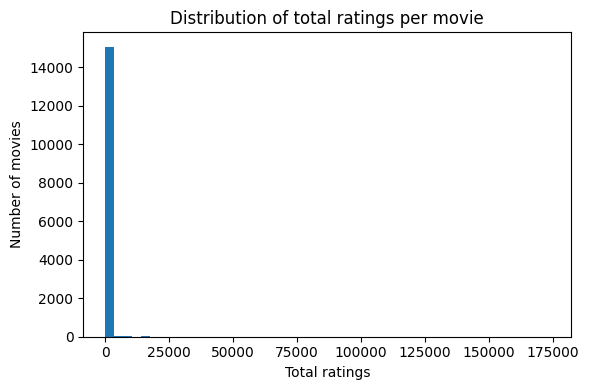

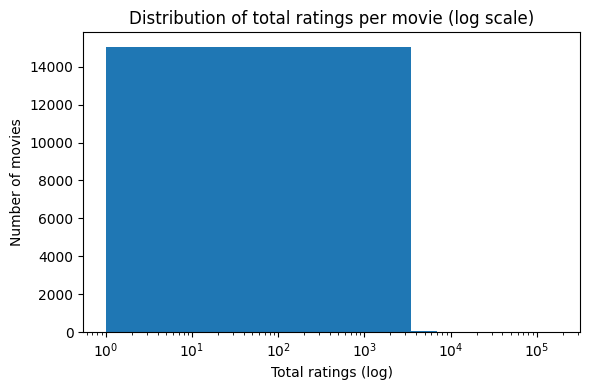

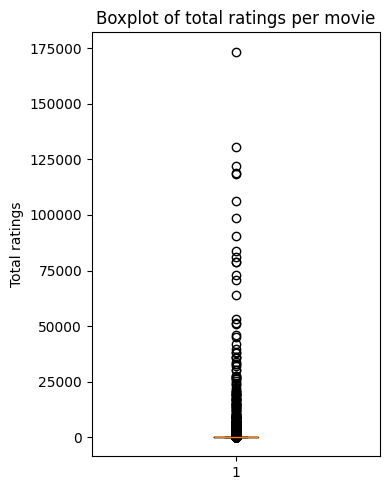

In [10]:
# 1.2.2 Distribution: total number of ratings per movie

data = movie_statistics["total_ratings"].dropna()

print("Mean:", data.mean())
print("Median:", data.median())

plt.figure(figsize=(6,4))
plt.hist(data, bins=50)
plt.title("Distribution of total ratings per movie")
plt.xlabel("Total ratings")
plt.ylabel("Number of movies")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.hist(data, bins=50)
plt.xscale("log")
plt.title("Distribution of total ratings per movie (log scale)")
plt.xlabel("Total ratings (log)")
plt.ylabel("Number of movies")
plt.tight_layout()
plt.show()

plt.figure(figsize=(4,5))
plt.boxplot(data, vert=True)
plt.title("Boxplot of total ratings per movie")
plt.ylabel("Total ratings")
plt.tight_layout()
plt.show()


Movie popularity is extremely long-tailed: most movies receive very few ratings, while a small minority concentrates a large fraction of interactions. This is reflected by the large mean–median gap and by the many extreme outliers in the boxplot. The log-scale histogram makes the heavy tail easier to interpret and motivates careful handling of popularity-driven skew in later steps.

Next, we examine *avg_rating*, which summarizes perceived quality at the item level. Compared to popularity variables, we expect a more compact distribution, with extreme values often associated with movies that have very few ratings.

Mean: 2.9998512158938007
Median: 3.0


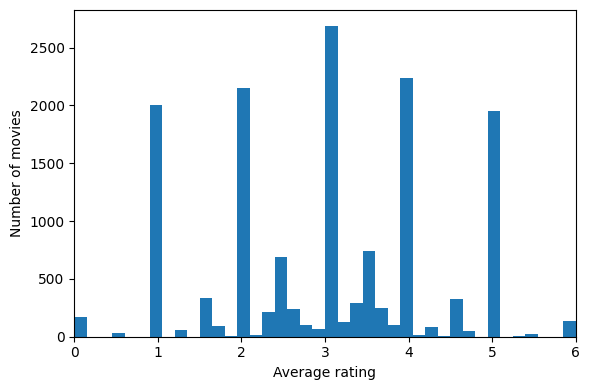

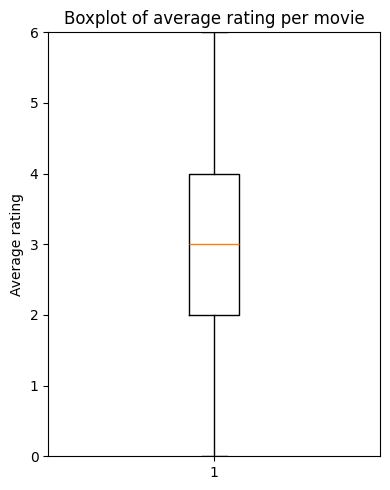

In [11]:
# 1.2.3 Distribution: average rating per movie

data = movie_statistics["avg_rating"].dropna()

print("Mean:", data.mean())
print("Median:", data.median())

plt.figure(figsize=(6,4))
plt.hist(data, bins=40, range=(0, 6))
plt.xlabel("Average rating")
plt.ylabel("Number of movies")
plt.xlim(0, 6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(4,5))
plt.boxplot(data, vert=True)
plt.title("Boxplot of average rating per movie")
plt.ylabel("Average rating")
plt.ylim(0, 6)
plt.tight_layout()
plt.show()

Average movie ratings typically concentrate around mid values, suggesting overall neutral-to-slightly-positive evaluations. The boxplot indicates meaningful variation across items, while extreme averages are often explained by low rating counts (noisy estimates for rarely rated movies).

We then analyze *std_rating*, which captures disagreement among viewers. This feature helps distinguish movies with broadly shared evaluations from titles that generate polarized responses.

Mean: 1.2579234787413824
Median: 1.2216989953222461


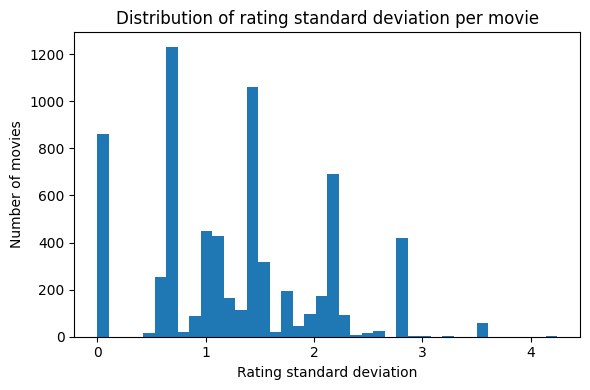

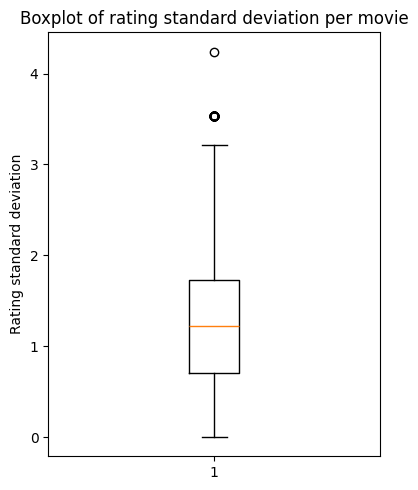

In [12]:
# 1.2.4 Distribution: standard deviation of ratings per movie

data = movie_statistics["std_rating"].dropna()

print("Mean:", data.mean())
print("Median:", data.median())

plt.figure(figsize=(6,4))
plt.hist(data, bins=40)
plt.title("Distribution of rating standard deviation per movie")
plt.xlabel("Rating standard deviation")
plt.ylabel("Number of movies")
plt.tight_layout()
plt.show()

plt.figure(figsize=(4,5))
plt.boxplot(data, vert=True)
plt.title("Boxplot of rating standard deviation per movie")
plt.ylabel("Rating standard deviation")
plt.tight_layout()
plt.show()

Most movies show moderate rating dispersion, indicating some disagreement but not extreme volatility. The right tail and boxplot outliers highlight a smaller subset of movies with highly variable ratings, consistent with “polarizing” items that split audience opinions.

To complement *total_ratings*, we inspect *unique_users*, which measures audience breadth. This metric is also expected to be long-tailed, so we again compare linear and log-scale histograms and include a boxplot to visualize the most extreme cases.

Mean: 251.86434439697666
Median: 1.0


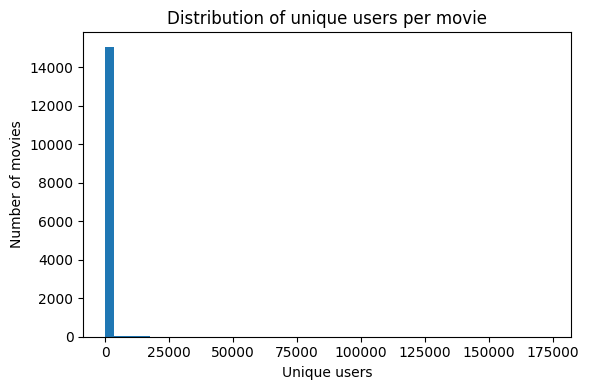

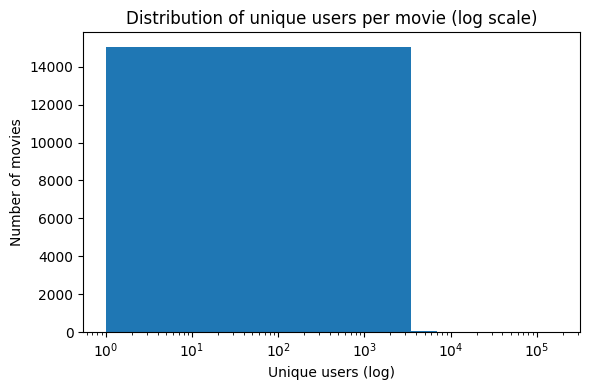

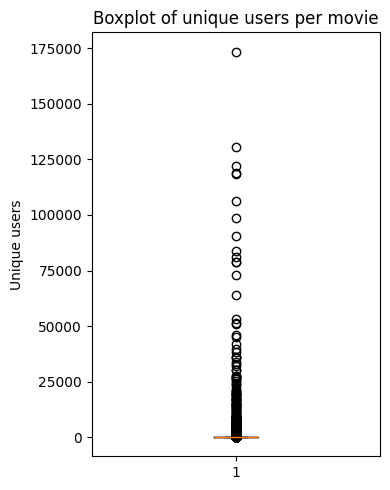

In [13]:
# 1.2.5 Distribution: unique users per movie

data = movie_statistics["unique_users"].dropna()

print("Mean:", data.mean())
print("Median:", data.median())

plt.figure(figsize=(6,4))
plt.hist(data, bins=50)
plt.title("Distribution of unique users per movie")
plt.xlabel("Unique users")
plt.ylabel("Number of movies")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.hist(data, bins=50)
plt.xscale("log")
plt.title("Distribution of unique users per movie (log scale)")
plt.xlabel("Unique users (log)")
plt.ylabel("Number of movies")
plt.tight_layout()
plt.show()

plt.figure(figsize=(4,5))
plt.boxplot(data, vert=True)
plt.title("Boxplot of unique users per movie")
plt.ylabel("Unique users")
plt.tight_layout()
plt.show()

The number of unique users per movie is highly right-skewed: most movies reach only a small audience, while a limited set attracts very large audiences. The mean–median gap and the extreme boxplot outliers reinforce the long-tail structure typical of item popularity in recommender datasets.

We now compare popularity and perceived quality by plotting *total_ratings* against *avg_rating*. Using a log scale on the x-axis makes it easier to interpret the large range of popularity values and to check whether popular items are systematically rated higher (or not).

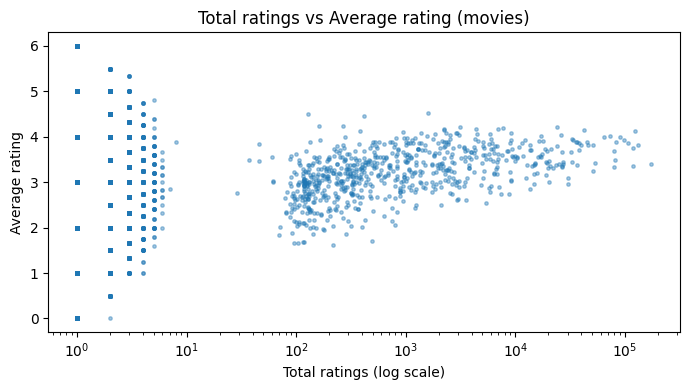

In [14]:
# 1.2.6 Scatter: popularity vs quality (log scale)

if {"total_ratings", "avg_rating"}.issubset(movie_statistics.columns):
    df = movie_statistics[["total_ratings", "avg_rating"]].dropna()

    plt.figure(figsize=(7,4))
    plt.scatter(df["total_ratings"], df["avg_rating"], s=6, alpha=0.4)
    plt.xscale("log")
    plt.title("Total ratings vs Average rating (movies)")
    plt.xlabel("Total ratings (log scale)")
    plt.ylabel("Average rating")
    plt.tight_layout()
    plt.show()

The scatter plot typically shows no strong linear relationship between popularity and average rating: highly rated movies can be either niche or widely watched. Items with very few ratings show much higher variability in *avg_rating*, while frequently rated movies tend to concentrate within a narrower band, suggesting more stable quality estimates as the number of ratings increases.

Finally, we compute correlations among the main movie features to detect overlap. In particular, we expect *total_ratings* and *unique_users* to be strongly correlated because both measure popularity from slightly different angles.

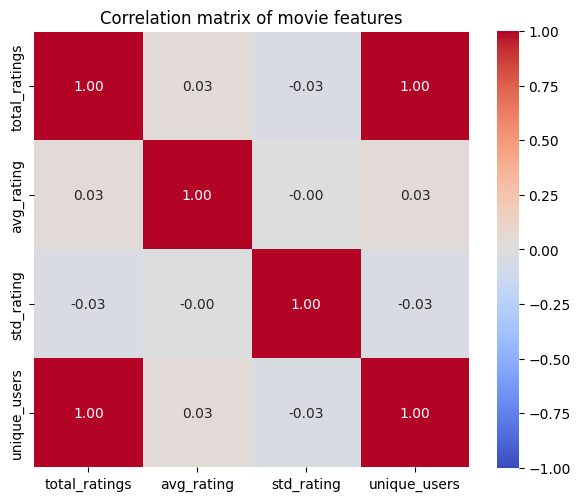

In [15]:
# 1.2.7 Movie features – Correlation heatmap

movie_corr_cols = [
    "total_ratings",
    "avg_rating",
    "std_rating",
    "unique_users"
]

movie_corr_cols = [c for c in movie_corr_cols if c in movie_statistics.columns]

corr_movies = movie_statistics[movie_corr_cols].corr()

plt.figure(figsize=(6,5))
sns.heatmap(
    corr_movies,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    square=True
)
plt.title("Correlation matrix of movie features")
plt.tight_layout()
plt.show()

The heatmap usually reveals a near-perfect correlation between *total_ratings* and *unique_users*, indicating that they capture very similar popularity information. In contrast, *avg_rating* and *std_rating* tend to correlate weakly with popularity, suggesting that perceived quality and disagreement are largely independent from how widely a movie is watched.

# **2. PREPROCESSING**

In this section, we clean and prepare all core datasets (*viewer_ratings*, *movies*, *user_statistics*, *movie_statistics*) to ensure consistency and reliability for downstream analysis. We handle missing values, invalid records, duplicates, and type conversions, applying median imputation for numerical features to preserve dataset size and robustness. Outliers are treated conservatively (only extreme activity levels) to reduce distortion in clustering. Finally, we standardize numerical features so that variables with different scales contribute comparably to user- and movie-level clustering.

The correlation heatmaps in Section 1.1.6 (user features) and Section 1.2.7 (movie features) show that some activity/popularity variables are strongly redundant: *total_ratings* correlates highly with *unique_movies* for users and with *unique_users* for movies. Even if they overlap statistically, they capture different concepts: *total_ratings* measures interaction volume, while *unique_movies* / *unique_users* measure breadth of exposure. For example, two users may have the same *total_ratings*, but one may rate many distinct movies (explorer) while another may rate fewer titles repeatedly (focused/rewatcher). Since our objective is interpretative clustering (behavioral profiling) rather than prediction, we keep both signals instead of dropping one during preprocessing.

We start from the raw *viewer_ratings* table and apply basic quality checks: missing values, type conversion for dates, validation of ratings (0–6 scale), and duplicate removal. We drop rows with missing keys (*movie_id*, *customer_id*) to preserve referential integrity, and we discard records flagged with an *anomalous_date* (keeping only rows where *anomalous_date* is NaN).

In [16]:
# 2.1 VIEWER_RATINGS

viewer_ratings_clean = viewer_ratings.copy()

print("Initial viewer_ratings shape:", viewer_ratings_clean.shape)
display(viewer_ratings_clean.head())
print("\nMissing values before cleaning (viewer_ratings):")
print(viewer_ratings_clean.isnull().sum())

# Convert `date` to datetime (invalid values -> NaT)
if "date" in viewer_ratings_clean.columns:
    viewer_ratings_clean["date"] = pd.to_datetime(
        viewer_ratings_clean["date"], errors="coerce"
    )

# Treat anomalous_date == "None" as missing (if present)
if "anomalous_date" in viewer_ratings_clean.columns:
    viewer_ratings_clean["anomalous_date"] = (
        viewer_ratings_clean["anomalous_date"].replace("None", np.nan)
    )

    viewer_ratings_clean = viewer_ratings_clean[
        ~(viewer_ratings_clean["anomalous_date"] == 1)
    ]

# Drop rows with missing keys (movie_id or customer_id)
viewer_ratings_clean = viewer_ratings_clean.dropna(subset=["movie_id", "customer_id"])

# Drop rows with missing ratings
viewer_ratings_clean = viewer_ratings_clean.dropna(subset=["rating"])

# Keep valid rating range for this dataset (0–6)
viewer_ratings_clean = viewer_ratings_clean[
    (viewer_ratings_clean["rating"] >= 0.0) &
    (viewer_ratings_clean["rating"] <= 6.0)
]

# Remove perfect duplicates
viewer_ratings_clean = viewer_ratings_clean.drop_duplicates()

# Reset index
viewer_ratings_clean = viewer_ratings_clean.reset_index(drop=True)

print("\n\nCleaned viewer_ratings shape:", viewer_ratings_clean.shape)
display(viewer_ratings_clean.head())
print("\nMissing values after cleaning (viewer_ratings):")
print(viewer_ratings_clean.isnull().sum())


Initial viewer_ratings shape: (4025000, 5)


,movie_id,customer_id,rating,date,anomalous_date
0,17,1481737,3.0,2005-10-09,NaN
1,9236,1448424,5.0,2005-11-15,NaN
2,4640,2308980,NaN,2005-08-06,NaN
3,9330,674346,3.0,2005-04-29,NaN
4,4570,1304045,4.0,2005-09-19,NaN



Missing values before cleaning (viewer_ratings):
movie_id                0
customer_id             0
rating             402500
date                    0
anomalous_date    4023791
dtype: int64


Cleaned viewer_ratings shape: (3621397, 5)


,movie_id,customer_id,rating,date,anomalous_date
0,17,1481737,3.0,2005-10-09,NaN
1,9236,1448424,5.0,2005-11-15,NaN
2,9330,674346,3.0,2005-04-29,NaN
3,4570,1304045,4.0,2005-09-19,NaN
4,9320,1036533,5.0,2004-08-05,NaN



Missing values after cleaning (viewer_ratings):
movie_id                0
customer_id             0
rating                  0
date                    0
anomalous_date    3621397
dtype: int64


In [17]:
viewer_ratings_clean["anomalous_date"].notna().sum()

np.int64(0)

The before/after shapes and missing-value counts confirm that invalid and incomplete interaction records have been removed. In particular, *anomalous_date* becomes entirely missing after cleaning because all rows with an anomalous value are excluded. This produces a consistent ratings table that can be safely linked to user- and movie-level summaries.

Next, we clean the movies table by enforcing the presence of the primary key (*movie_id* ), removing duplicate items, and ensuring key descriptive fields are present. We also impute missing *year_of_release* values using the median to avoid losing items during merges.

In [18]:
# 2.2 MOVIES

movies_clean = movies.copy()

print("Initial movies shape:", movies_clean.shape)
display(movies_clean.head())
print("\nMissing values before cleaning (movies):")
print(movies_clean.isnull().sum())

# Drop rows with missing movie_id (primary key)
movies_clean = movies_clean.dropna(subset=["movie_id"])

# Remove duplicate movie_id rows (keep first occurrence)
movies_clean = movies_clean.drop_duplicates(subset=["movie_id"], keep="first")

# Drop rows with missing title
if "title" in movies_clean.columns:
    movies_clean = movies_clean.dropna(subset=["title"])

# After cleaning release_year, force imputation to remove ALL NaN
movies_clean["year_of_release"] = movies_clean["year_of_release"].fillna(
    movies_clean["year_of_release"].median()
)

# Ensure no missing values remain
movies_clean = movies_clean.dropna(subset=["year_of_release", "title"])

print("\n\nCleaned movies shape:", movies_clean.shape)
display(movies_clean.head())
print("\nMissing values after cleaning (movies):")
print(movies_clean.isnull().sum())


Initial movies shape: (18008, 3)


,movie_id,year_of_release,title
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW



Missing values before cleaning (movies):
movie_id           0
year_of_release    7
title              0
dtype: int64


Cleaned movies shape: (18006, 3)


,movie_id,year_of_release,title
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW



Missing values after cleaning (movies):
movie_id           0
year_of_release    0
title              0
dtype: int64


At this point, each movie has a valid identifier and core metadata. Median imputation on year_of_release preserves coverage while keeping the transformation simple and robust.

Before cleaning movie-level statistics, we inspect the table and missing values. This step clarifies which features require numeric conversion and imputation.

In [19]:
# 2.3.1 MOVIE_STATISTICS — Initial inspection

movie_statistics_clean = movie_statistics.copy()

print("Initial movie_statistics shape:", movie_statistics_clean.shape)
display(movie_statistics_clean.head())
print("\nMissing values before cleaning (movie_statistics):")
print(movie_statistics_clean.isnull().sum())


Initial movie_statistics shape: (16015, 11)


,movie_id,total_ratings,avg_rating,std_rating,min_rating,max_rating,unique_users,first_rating_date,last_rating_date,year_of_release,title
0,1,548.0,3.744526,1.073389,1.0,5.0,548.0,2003-07-12,2005-12-30,2003.0,Dinosaur Planet
1,2,146.0,3.547945,1.281606,1.0,5.0,146.0,2004-10-16,2005-12-20,2004.0,Isle of Man TT 2004 Review
2,3,2013.0,3.639841,0.978873,1.0,5.0,2013.0,2000-10-19,2005-12-30,1997.0,Character
3,4,142.0,2.739437,1.302913,1.0,5.0,142.0,2003-12-06,2005-12-27,1994.0,Paula Abdul's Get Up & Dance
4,5,1140.0,3.919298,1.292436,1.0,5.0,1140.0,2004-11-02,2005-12-29,2004.0,The Rise and Fall of ECW



Missing values before cleaning (movie_statistics):
movie_id                0
total_ratings         800
avg_rating            800
std_rating           9168
min_rating            800
max_rating            800
unique_users          800
first_rating_date       0
last_rating_date        0
year_of_release      4511
title                4507
dtype: int64


The missing-value summary indicates which numerical fields need conversion to numeric types and which require imputation to avoid downstream errors during scaling and clustering.

We enforce valid keys (*movie_id* ), remove duplicates, convert numerical fields with errors = "coerce", and apply median imputation for robustness. This ensures we retain as many movies as possible while avoiding NaNs in clustering features.

In [20]:
# 2.3.2 MOVIE_STATISTICS — Cleaning + numeric conversion + missing checks

# Drop rows with missing movie_id
movie_statistics_clean = movie_statistics_clean.dropna(subset=["movie_id"])

# Remove duplicated movie_id
movie_statistics_clean = movie_statistics_clean.drop_duplicates(subset=["movie_id"], keep="first")

# Numeric columns for movie-level stats
movie_stat_cols = [
    "total_ratings",
    "avg_rating",
    "std_rating",
    "min_rating",
    "max_rating",
    "unique_users",
]
movie_stat_cols = [c for c in movie_stat_cols if c in movie_statistics_clean.columns]

print("\nNumeric columns used for movie_statistics cleaning:", movie_stat_cols)

# Convert to numeric
for col in movie_stat_cols:
    movie_statistics_clean[col] = pd.to_numeric(
        movie_statistics_clean[col], errors="coerce"
    )

# Median imputation
for col in movie_stat_cols:
    median_val = movie_statistics_clean[col].median()
    movie_statistics_clean[col] = movie_statistics_clean[col].fillna(median_val)

movie_statistics_clean = movie_statistics_clean.reset_index(drop=True)

print("\nCleaned movie_statistics shape:", movie_statistics_clean.shape)
display(movie_statistics_clean.head())
print("\nMissing values after cleaning (movie_statistics):")
print(movie_statistics_clean[movie_stat_cols].isnull().sum())



Numeric columns used for movie_statistics cleaning: ['total_ratings', 'avg_rating', 'std_rating', 'min_rating', 'max_rating', 'unique_users']

Cleaned movie_statistics shape: (16013, 11)


,movie_id,total_ratings,avg_rating,std_rating,min_rating,max_rating,unique_users,first_rating_date,last_rating_date,year_of_release,title
0,1,548.0,3.744526,1.073389,1.0,5.0,548.0,2003-07-12,2005-12-30,2003.0,Dinosaur Planet
1,2,146.0,3.547945,1.281606,1.0,5.0,146.0,2004-10-16,2005-12-20,2004.0,Isle of Man TT 2004 Review
2,3,2013.0,3.639841,0.978873,1.0,5.0,2013.0,2000-10-19,2005-12-30,1997.0,Character
3,4,142.0,2.739437,1.302913,1.0,5.0,142.0,2003-12-06,2005-12-27,1994.0,Paula Abdul's Get Up & Dance
4,5,1140.0,3.919298,1.292436,1.0,5.0,1140.0,2004-11-02,2005-12-29,2004.0,The Rise and Fall of ECW



Missing values after cleaning (movie_statistics):
total_ratings    0
avg_rating       0
std_rating       0
min_rating       0
max_rating       0
unique_users     0
dtype: int64


After conversion and median imputation, the selected movie-level numeric columns contain no missing values, which prevents failures during scaling and ensures consistent feature matrices.

We apply the same strategy to *user_statistics*: remove duplicate users, correct impossible values (e.g., negative *activity_days*), convert to numeric, and use median imputation to preserve user coverage.

N.B.: The original activity_days feature contains missing values for a subset of users, leading to unnecessary data loss when rows are dropped. Since the dataset provides first_rating_days and last_rating_days, we reconstruct activity_days by converting these columns to datetime and computing the time span between the first and last rating.  
This approach preserves additional users while maintaining a meaningful and interpretable measure of user activity duration.


In [21]:
# 2.4 USER_STATISTICS

user_statistics_clean = user_statistics.copy()

print("Initial user_statistics shape:", user_statistics_clean.shape)
display(user_statistics_clean.head())
print("\nMissing values before cleaning (user_statistics):")
print(user_statistics_clean.isnull().sum())

# Remove duplicate user IDs
user_statistics_clean = user_statistics_clean.drop_duplicates(
    subset=["customer_id"], keep="first"
)

# Reconstruct activity_days from first/last rating timestamps
if {"first_rating_days", "last_rating_days"}.issubset(user_statistics_clean.columns):
    user_statistics_clean["first_rating_days"] = pd.to_datetime(
        user_statistics_clean["first_rating_days"], errors="coerce"
    )
    user_statistics_clean["last_rating_days"] = pd.to_datetime(
        user_statistics_clean["last_rating_days"], errors="coerce"
    )

    user_statistics_clean["activity_days"] = (
        user_statistics_clean["last_rating_days"] -
        user_statistics_clean["first_rating_days"]
    ).dt.days

    # Remove inconsistent spans (negative values)
    user_statistics_clean.loc[
        user_statistics_clean["activity_days"] < 0, "activity_days"
    ] = np.nan
else:
    # Fallback: if activity_days exists, just clean impossible values
    if "activity_days" in user_statistics_clean.columns:
        user_statistics_clean.loc[
            user_statistics_clean["activity_days"] < 0, "activity_days"
        ] = np.nan

# Convert numeric columns (do not include activity_days here)
numeric_cols = [
    "total_ratings",
    "avg_rating",
    "std_rating",
    "min_rating",
    "max_rating",
    "unique_movies"
]
numeric_cols = [c for c in numeric_cols if c in user_statistics_clean.columns]

for col in numeric_cols:
    user_statistics_clean[col] = pd.to_numeric(
        user_statistics_clean[col], errors="coerce"
    )

# Ensure activity_days is numeric (it already is if reconstructed)
if "activity_days" in user_statistics_clean.columns:
    user_statistics_clean["activity_days"] = pd.to_numeric(
        user_statistics_clean["activity_days"], errors="coerce"
    )

# Median imputation
impute_cols = numeric_cols + (["activity_days"] if "activity_days" in user_statistics_clean.columns else [])
for col in impute_cols:
    median_val = user_statistics_clean[col].median()
    user_statistics_clean[col] = user_statistics_clean[col].fillna(median_val)

user_statistics_clean = user_statistics_clean.reset_index(drop=True)

print("\n\nCleaned user_statistics shape:", user_statistics_clean.shape)
display(user_statistics_clean.head())

print("\nMissing values after cleaning (user_statistics):")
print(user_statistics_clean[impute_cols].isnull().sum())



Initial user_statistics shape: (438780, 10)


,customer_id,total_ratings,avg_rating,std_rating,min_rating,max_rating,unique_movies,first_rating_date,last_rating_date,activity_days
0,1965326,8.0,3.250000,0.886405,2.0,5.0,8.0,2004-08-11,2005-06-06,299.0
1,506434,1.0,4.000000,NaN,4.0,4.0,1.0,2005-08-02,2005-08-02,0.0
2,1365167,3.0,4.666667,0.577350,4.0,5.0,3.0,2004-11-16,2005-01-19,64.0
3,396632,2.0,NaN,0.000000,4.0,4.0,2.0,2004-07-07,2004-07-07,0.0
4,260614,3.0,4.333333,0.577350,4.0,5.0,3.0,2004-03-02,2004-10-13,NaN



Missing values before cleaning (user_statistics):
customer_id               0
total_ratings         21939
avg_rating            21939
std_rating           106252
min_rating            21939
max_rating            21939
unique_movies         21939
first_rating_date         0
last_rating_date          0
activity_days         21939
dtype: int64


Cleaned user_statistics shape: (438780, 10)


,customer_id,total_ratings,avg_rating,std_rating,min_rating,max_rating,unique_movies,first_rating_date,last_rating_date,activity_days
0,1965326,8.0,3.250000,0.886405,2.0,5.0,8.0,2004-08-11,2005-06-06,299.0
1,506434,1.0,4.000000,0.867759,4.0,4.0,1.0,2005-08-02,2005-08-02,0.0
2,1365167,3.0,4.666667,0.577350,4.0,5.0,3.0,2004-11-16,2005-01-19,64.0
3,396632,2.0,3.687500,0.000000,4.0,4.0,2.0,2004-07-07,2004-07-07,0.0
4,260614,3.0,4.333333,0.577350,4.0,5.0,3.0,2004-03-02,2004-10-13,102.0



Missing values after cleaning (user_statistics):
total_ratings    0
avg_rating       0
std_rating       0
min_rating       0
max_rating       0
unique_movies    0
activity_days    0
dtype: int64


This produces a clean user-level table with consistent numeric feature types and no missing values in the selected columns, which is required for scaling and clustering.

We now define the numerical feature set used for user-level clustering and build the *user_features* table. Keeping the identifier (*customer_id* ) allows traceability and later joins.

In [22]:
# 2.5 User-level features & scaling

# 2.5.1 Select numerical features for user-level clustering
user_feature_cols = [
    "total_ratings",
    "avg_rating",
    "std_rating",
    "min_rating",
    "max_rating",
    "unique_movies",
    "activity_days",
]

# Keep only columns that actually exist
user_feature_cols = [c for c in user_feature_cols if c in user_statistics_clean.columns]

user_features = user_statistics_clean[["customer_id"] + user_feature_cols].copy()

print("Initial user_features shape:", user_features.shape)
display(user_features.head())


Initial user_features shape: (438780, 8)


,customer_id,total_ratings,avg_rating,std_rating,min_rating,max_rating,unique_movies,activity_days
0,1965326,8.0,3.250000,0.886405,2.0,5.0,8.0,299.0
1,506434,1.0,4.000000,0.867759,4.0,4.0,1.0,0.0
2,1365167,3.0,4.666667,0.577350,4.0,5.0,3.0,64.0
3,396632,2.0,3.687500,0.000000,4.0,4.0,2.0,0.0
4,260614,3.0,4.333333,0.577350,4.0,5.0,3.0,102.0


The resulting table defines the final user representation for clustering: engagement intensity, breadth, persistence, and rating behavior statistics.

To reduce the impact of extreme heavy users on centroid-based clustering, we remove only the most extreme activity outliers by filtering *user_features* at the 99th percentile of *total_ratings*, producing *user_features_clean*. This conservative step improves cluster stability without aggressively trimming the dataset.

In [23]:
# 2.5.2 Remove extreme outliers in total_ratings (user-level)

if "total_ratings" in user_feature_cols:
    upper_thr_users = user_features["total_ratings"].quantile(0.99)
    user_features_clean = user_features[user_features["total_ratings"] <= upper_thr_users].reset_index(drop=True)
else:
    user_features_clean = user_features.copy().reset_index(drop=True)

print("Shape after removing extreme outliers (user_features_clean):", user_features_clean.shape)

Shape after removing extreme outliers (user_features_clean): (434429, 8)


After filtering, the user feature table retains the vast majority of users while reducing the leverage of extreme activity points.

We standardize user numerical features using StandardScaler. This ensures that variables on different scales (e.g., counts vs ratings) contribute comparably when computing distances for clustering.

In [24]:
# 2.5.3 Standardize numerical features (user-level)

user_scaler = StandardScaler()
X_users = user_features_clean[user_feature_cols].values
X_users_scaled = user_scaler.fit_transform(X_users)

print("Scaled user feature matrix shape:", X_users_scaled.shape)

Scaled user feature matrix shape: (434429, 7)


The scaled matrix is the final input representation for user clustering models.


We now define the numerical feature set used for movie-level clustering and build the *movie_features* table. As for users, we retain the identifier (*movie_id* ) for traceability.

In [25]:
# 2.6 Movie-level features & scaling
# 2.6.1 Select numerical features for movie-level clustering

movie_feature_cols = [
    "total_ratings",
    "avg_rating",
    "std_rating",
    "min_rating",
    "max_rating",
    "unique_users",
]
movie_feature_cols = [c for c in movie_feature_cols if c in movie_statistics_clean.columns]

movie_features = movie_statistics_clean[["movie_id"] + movie_feature_cols].copy()

print("Initial movie_features shape:", movie_features.shape)
display(movie_features.head())

Initial movie_features shape: (16013, 7)


,movie_id,total_ratings,avg_rating,std_rating,min_rating,max_rating,unique_users
0,1,548.0,3.744526,1.073389,1.0,5.0,548.0
1,2,146.0,3.547945,1.281606,1.0,5.0,146.0
2,3,2013.0,3.639841,0.978873,1.0,5.0,2013.0
3,4,142.0,2.739437,1.302913,1.0,5.0,142.0
4,5,1140.0,3.919298,1.292436,1.0,5.0,1140.0


This table summarizes each movie with popularity, quality, and dispersion signals, forming the basis for movie clustering.

We standardize movie numerical features for the same reason as users: clustering distance metrics should not be dominated by high-magnitude variables such as popularity counts.

In [26]:
# 2.6.2 Standardize numerical features (movie-level)

movie_scaler = StandardScaler()
X_movies = movie_features[movie_feature_cols].values
X_movies_scaled = movie_scaler.fit_transform(X_movies)

print("Scaled movie feature matrix shape:", X_movies_scaled.shape)

Scaled movie feature matrix shape: (16013, 6)


The resulting scaled matrix is the final representation used by movie clustering models.

Before modeling, we validate basic referential integrity: every *customer_id* and *movie_id* present in *viewer_ratings_clean* should also exist in the cleaned user/movie feature tables. This prevents “orphan” interactions that would break merges or cluster assignment.

In [27]:
user_coverage = viewer_ratings_clean["customer_id"].isin(user_features_clean["customer_id"]).mean()
movie_coverage = viewer_ratings_clean["movie_id"].isin(movie_features["movie_id"]).mean()

print("User coverage in ratings vs user_features_clean:", user_coverage)
print("Movie coverage in ratings vs movie_features:", movie_coverage)

User coverage in ratings vs user_features_clean: 0.9143954667218204
Movie coverage in ratings vs movie_features: 1.0


In this validation step, we check identifier consistency across the cleaned datasets before modeling. Movie coverage is complete, confirming there are no orphan ratings linked to missing movies. User coverage is intentionally below 100% because extreme heavy users were removed during outlier filtering; as a result, a small share of ratings belongs to excluded users. Overall, the remaining datasets can be safely merged and used for clustering.

# **3. HELPER FUNCTIONS: CENTROID SILHOUETTE & WCSS**


This section defines lightweight utility functions used to evaluate clustering outputs in a consistent way across different algorithms. In particular, we introduce a scalable approximation of the Silhouette score (centroid-based) and a generic implementation of WCSS. Together, these metrics support model selection by providing complementary signals: separation/compactness (Silhouette-like) and within-cluster variance (WCSS).

The standard Silhouette score is often impractical on very large datasets because it requires computing pairwise distances between points (O(n²) complexity). To keep evaluation scalable, we implement a centroid-based Silhouette that approximates the original idea using distances to centroids instead of all point-to-point distances.

In [28]:
# 3.1 Centroid-based Silhouette

def centroid_silhouette(X, labels):
    X = np.asarray(X)
    labels = np.asarray(labels)

    # Check that at least 2 clusters exist
    unique_labels = np.unique(labels)
    k = len(unique_labels)
    if k < 2:
        return np.nan

    # Compute centroids for each cluster
    centroids = np.array([
        X[labels == c].mean(axis=0)
        for c in unique_labels
    ])

    # Distance from each point to each centroid
    dist_matrix = np.sqrt(
        ((X[:, None, :] - centroids[None, :, :]) ** 2).sum(axis=2)
    )

    # Index of the cluster of each point
    cluster_index = np.array([
        np.where(unique_labels == lab)[0][0] for lab in labels
    ])

    # a(i): distance to own cluster centroid
    a = dist_matrix[np.arange(len(X)), cluster_index]

    # b(i): smallest distance to any other centroid
    b = []
    for i in range(len(X)):
        own_c = cluster_index[i]
        other_dists = np.delete(dist_matrix[i], own_c)
        b.append(other_dists.min())
    b = np.array(b)

    # Silhouette for each point
    s = (b - a) / np.maximum(a, b)

    return float(np.mean(s))

This approximation retains the core Silhouette intuition: each point is evaluated based on (i) how close it is to its own cluster (cohesion) and (ii) how far it is from the nearest alternative cluster (separation), but using centroid distances to remain computationally efficient.

We also define a generic WCSS (Within-Cluster Sum of Squares) function that can be computed from any clustering assignment (K-Means, MiniBatch K-Means, BIRCH, etc.). This is useful for elbow-style diagnostics and for comparing compactness across models.

In [29]:
# 3.2 Compute WCSS given labels (generic, for K-Means / MiniBatch / BIRCH)

def compute_wcss(X, labels):
    X = np.asarray(X)
    labels = np.asarray(labels)

    unique_labels = np.unique(labels)
    wcss = 0.0
    for c in unique_labels:
        cluster_points = X[labels == c]
        centroid = cluster_points.mean(axis=0)
        wcss += ((cluster_points - centroid) ** 2).sum()
    return float(wcss)


WCSS measures how tightly points cluster around their assigned centroids: lower values indicate more compact clusters. While WCSS typically decreases as the number of clusters increases, its rate of decrease helps identify “elbow” regions where additional clusters yield diminishing returns.

# **4. USER CLUSTERING (K-Means, MiniBatch K-Means, BIRCH)**

In this section, we cluster users using three scalable centroid-based methods (K-Means, MiniBatch K-Means, and BIRCH) on the standardized user feature matrix. We test a range of k values and evaluate each configuration with two complementary criteria: WCSS (Elbow method) to measure compactness and centroid-based Silhouette to approximate separation at scale. We then select a final global k using a consensus rule (majority vote across models; otherwise the k that maximizes the average silhouette). Finally, we fit the three models with the chosen k, store cluster labels, visualize the results through a 2D PCA projection, and compare the final solutions using silhouette, cluster-size balance, and computation time.

We define the range of cluster counts to test. The interval is kept small to balance interpretability and computational cost while still allowing clear elbow/silhouette trends to emerge.

In [30]:
# 4.1 Range of k values to explore

k_values = list(range(3, 10))
print("k_values:", k_values)


k_values: [3, 4, 5, 6, 7, 8, 9]


These k values are used consistently across the three algorithms to make the evaluation curves directly comparable.

We run K-Means for each k and collect two metrics: (i) WCSS via the model inertia and (ii) centroid-based Silhouette via our helper function. Plotting both curves supports a trade-off analysis between compactness and separation.

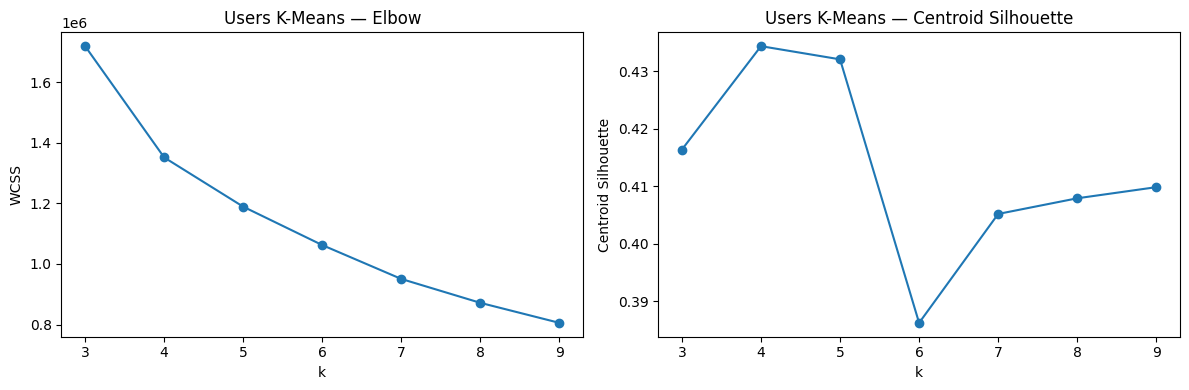

In [31]:
# 4.2 User K-Means — Elbow & Centroid Silhouette

kmeans_users_wcss = []
kmeans_users_cs   = []

for k in k_values:
    model = KMeans(
        n_clusters=k,
        init="k-means++",
        n_init=10,
        random_state=42
    )
    labels = model.fit_predict(X_users_scaled)

    kmeans_users_wcss.append(model.inertia_)
    kmeans_users_cs.append(centroid_silhouette(X_users_scaled, labels))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(k_values, kmeans_users_wcss, marker='o')
axes[0].set_title("Users K-Means — Elbow")
axes[0].set_xlabel("k"); axes[0].set_ylabel("WCSS")

axes[1].plot(k_values, kmeans_users_cs, marker='o')
axes[1].set_title("Users K-Means — Centroid Silhouette")
axes[1].set_xlabel("k"); axes[1].set_ylabel("Centroid Silhouette")

plt.tight_layout()
plt.show()


The Elbow curve decreases as k increases, with diminishing returns after the first few clusters, suggesting that adding many more clusters yields progressively smaller compactness gains. The centroid-based Silhouette typically peaks around a small k (often ~4–5) and may drop for larger values, indicating worse separation. Overall, these curves suggest a compact and interpretable solution with a small number of clusters.

We repeat the same evaluation for MiniBatch K-Means, which is designed for scalability on large datasets. We compute WCSS with the generic helper (to stay model-agnostic) and again track centroid-based Silhouette.

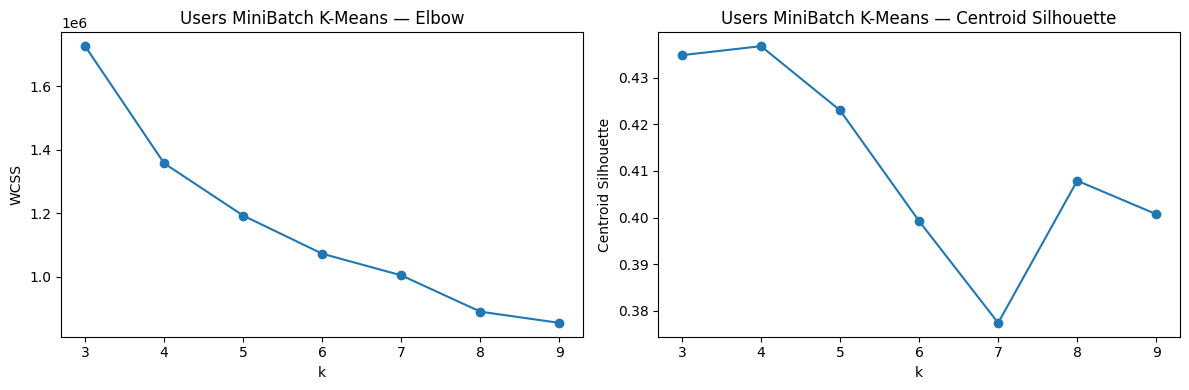

In [32]:
# 4.3 User MiniBatch K-Means — Elbow & Centroid Silhouette

minibatch_users_wcss = []
minibatch_users_cs   = []

for k in k_values:
    model = MiniBatchKMeans(
        n_clusters=k,
        init="k-means++",
        batch_size=10_000,
        n_init=5,
        random_state=42
    )
    labels = model.fit_predict(X_users_scaled)

    minibatch_users_wcss.append(compute_wcss(X_users_scaled, labels))
    minibatch_users_cs.append(centroid_silhouette(X_users_scaled, labels))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(k_values, minibatch_users_wcss, marker='o')
axes[0].set_title("Users MiniBatch K-Means — Elbow")
axes[0].set_xlabel("k"); axes[0].set_ylabel("WCSS")

axes[1].plot(k_values, minibatch_users_cs, marker='o')
axes[1].set_title("Users MiniBatch K-Means — Centroid Silhouette")
axes[1].set_xlabel("k"); axes[1].set_ylabel("Centroid Silhouette")

plt.tight_layout()
plt.show()


The Elbow curve usually shows a strong reduction in WCSS for small k values, followed by smaller incremental gains as k increases. The centroid-based Silhouette often peaks at a small k and decreases for larger ones, reinforcing the preference for a compact segmentation. MiniBatch K-Means typically mirrors K-Means trends while offering improved scalability.

We evaluate BIRCH over the same k range. BIRCH can produce good separation with fewer clusters, but it is also sensitive to parameters such as threshold and may generate imbalanced cluster assignments depending on the data geometry.

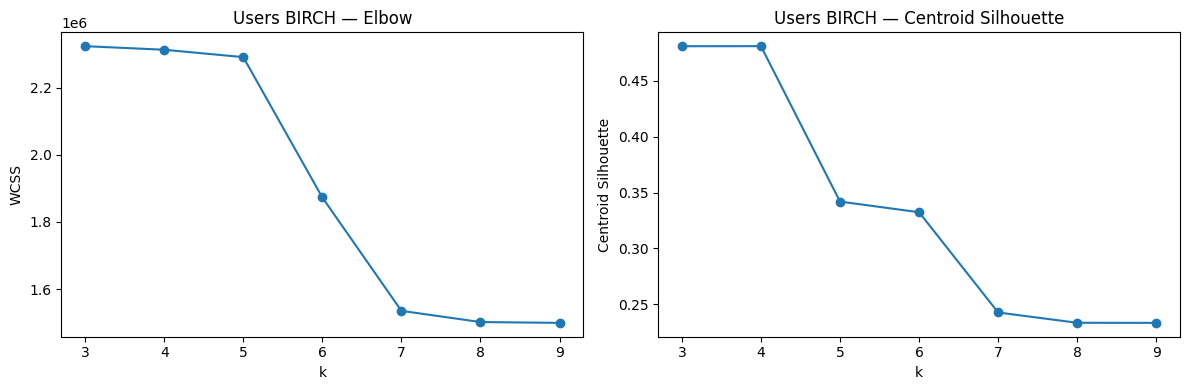

In [33]:
# 4.4 User BIRCH — Elbow & Centroid Silhouette

birch_users_wcss = []
birch_users_cs   = []

for k in k_values:
    model = Birch(
        n_clusters=k,
        threshold=0.5,
        branching_factor=50
    )
    labels = model.fit_predict(X_users_scaled)

    birch_users_wcss.append(compute_wcss(X_users_scaled, labels))
    birch_users_cs.append(centroid_silhouette(X_users_scaled, labels))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(k_values, birch_users_wcss, marker='o')
axes[0].set_title("Users BIRCH — Elbow")
axes[0].set_xlabel("k"); axes[0].set_ylabel("WCSS")

axes[1].plot(k_values, birch_users_cs, marker='o')
axes[1].set_title("Users BIRCH — Centroid Silhouette")
axes[1].set_xlabel("k"); axes[1].set_ylabel("Centroid Silhouette")

plt.tight_layout()
plt.show()


For BIRCH, the WCSS trend can differ from K-Means variants, but the centroid-based Silhouette often favors small k values, indicating better separation with fewer clusters. In practice, this may come at the cost of cluster imbalance, which is checked later during model comparison.


NB: Although the Elbow curves of the three methods do not show a very sharp “elbow”, we intentionally restricted the search range to small k values to keep a good model interpretability, reduce computational cost, and to avoid over-fragmentation. In cases where WCSS decreases smoothly, the Elbow criterion can be ambiguous, so we complement it with the centroid-based Silhouette score. In our results, the Silhouette clearly peaks at small k (≈4), indicating that increasing k further, to possibly show a better "elbow", would mainly fragment clusters without improving separation, and was therefore found unnecessary. For this reasons, the chosen k-range remains appropriate.

We select an overall k for user clustering by first identifying the best k per model according to centroid-based Silhouette. If at least two models agree, we adopt the majority choice. Otherwise, we choose the k that maximizes the average centroid-silhouette across the three models, ensuring a simple and reproducible consensus rule.


In [34]:
# 4.5 Choose best k for user clustering
# Best k according to Centroid Silhouette (per model)
best_k_kmeans_users_cs = k_values[np.argmax(kmeans_users_cs)]
best_k_birch_users_cs = k_values[np.argmax(birch_users_cs)]
best_k_minibatch_users_cs = k_values[np.argmax(minibatch_users_cs)]

print("USER clustering — Best k by Centroid Silhouette:")
print(f"K-Means: k = {best_k_kmeans_users_cs}")
print(f"BIRCH: k = {best_k_birch_users_cs}")
print(f"MiniBatch K-Means: k = {best_k_minibatch_users_cs}")

# Try majority vote on Centroid Silhouette
user_cs_ks = np.array([
    best_k_kmeans_users_cs,
    best_k_birch_users_cs,
    best_k_minibatch_users_cs
])
values_u, counts_u = np.unique(user_cs_ks, return_counts=True)

if counts_u.max() >= 2:
    # majority wins
    k_global_users = int(values_u[counts_u.argmax()])
    print("\nUSER clustering → at least two models agree on k by centroid silhouette → using majority vote")
else:
    # fallback: maximize average centroid silhouette across models
    kmeans_users_cs_arr = np.array(kmeans_users_cs, dtype=float)
    birch_users_cs_arr = np.array(birch_users_cs, dtype=float)
    minibatch_users_cs_arr = np.array(minibatch_users_cs, dtype=float)

    avg_cs_users = (kmeans_users_cs_arr + birch_users_cs_arr + minibatch_users_cs_arr) / 3.0
    best_idx_global_users = int(np.argmax(avg_cs_users))
    k_global_users = int(k_values[best_idx_global_users])

    print("\nUSER clustering → no agreement between models on centroid-silhouette-best k.")
    print("Using k that maximizes the AVERAGE centroid silhouette across all user models")

print("\n\nFINAL GLOBAL k for USERS:")
print(f"Chosen k_best_users = {k_global_users}")

k_best_users = k_global_users


USER clustering — Best k by Centroid Silhouette:
K-Means:           k = 4
BIRCH:             k = 4
MiniBatch K-Means: k = 4

USER clustering → at least two models agree on k by centroid silhouette → using majority vote


FINAL GLOBAL k for USERS:
Chosen k_best_users = 4


This step provides a transparent selection rule for k. The result is a single *k_best_users* that is then reused across K-Means, MiniBatch K-Means, and BIRCH to make the final clusterings directly comparable.

Using the chosen *k_best_users*, we fit the three clustering algorithms on the standardized feature matrix, store the resulting cluster labels in *user_features_clean*, and then merge them into *user_statistics_clean* via *customer_id*.

In [35]:
# 4.6 Final user clusters with K-Means, MiniBatch, BIRCH (store on user_features_clean)

# Final K-Means on users
kmeans_users_final = KMeans(
    n_clusters=k_best_users,
    init="k-means++",
    n_init=10,
    random_state=42
)
user_features_clean["cluster_kmeans"] = kmeans_users_final.fit_predict(X_users_scaled)

# Final MiniBatch K-Means on users
minibatch_users_final = MiniBatchKMeans(
    n_clusters=k_best_users,
    init="k-means++",
    batch_size=10_000,
    n_init=5,
    random_state=42
)
user_features_clean["cluster_minibatch"] = minibatch_users_final.fit_predict(X_users_scaled)

# Final BIRCH on users
birch_users_final = Birch(
    n_clusters=k_best_users,
    threshold=0.5,
    branching_factor=50
)
user_features_clean["cluster_birch"] = birch_users_final.fit_predict(X_users_scaled)

user_features_clean.head()


,customer_id,total_ratings,avg_rating,std_rating,min_rating,max_rating,unique_movies,activity_days,cluster_kmeans,cluster_minibatch,cluster_birch
0,1965326,8.0,3.250000,0.886405,2.0,5.0,8.0,299.0,3,3,0
1,506434,1.0,4.000000,0.867759,4.0,4.0,1.0,0.0,2,1,0
2,1365167,3.0,4.666667,0.577350,4.0,5.0,3.0,64.0,2,1,0
3,396632,2.0,3.687500,0.000000,4.0,4.0,2.0,0.0,2,1,0
4,260614,3.0,4.333333,0.577350,4.0,5.0,3.0,102.0,2,1,0


By merging cluster labels into the cleaned user data, we link each user’s behavioral profile to a specific cluster.


In [36]:
# Merge cluster labels back into user_statistics_clean

user_statistics_clean = user_statistics_clean.merge(
    user_features_clean[["customer_id", "cluster_kmeans", "cluster_minibatch", "cluster_birch"]],
    on="customer_id",
    how="inner"
)

print("user_statistics_clean now contains cluster columns:")
print([c for c in user_statistics_clean.columns if "cluster" in c])
print("Shape:", user_statistics_clean.shape)


user_statistics_clean now contains cluster columns:
['cluster_kmeans', 'cluster_minibatch', 'cluster_birch']
Shape: (434429, 13)


The cleaned dataset now contains 434,429 users, each enriched with cluster labels from all three models (K-Means, MiniBatch K-Means, and BIRCH), together with their cleaned statistics, making the data ready for downstream analysis and recommendation.

To visually inspect cluster structure, we project standardized user features into 2D using PCA. This does not define the clusters (clustering is performed in the full feature space), but it provides an interpretable visualization of how cluster assignments separate in a low-dimensional view.


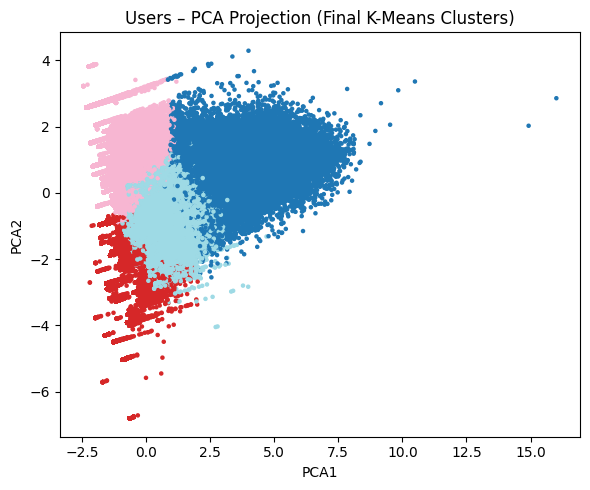

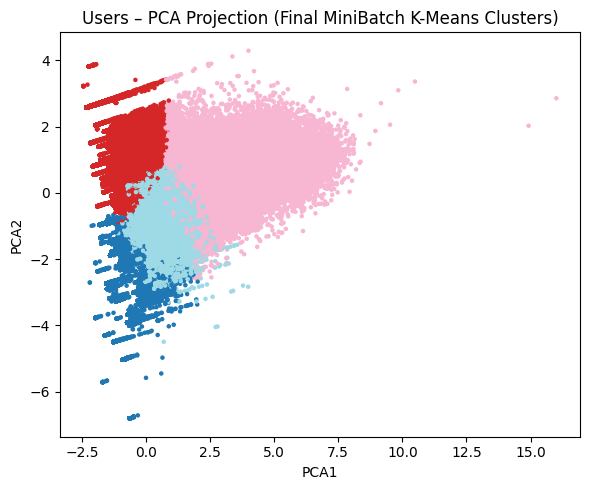

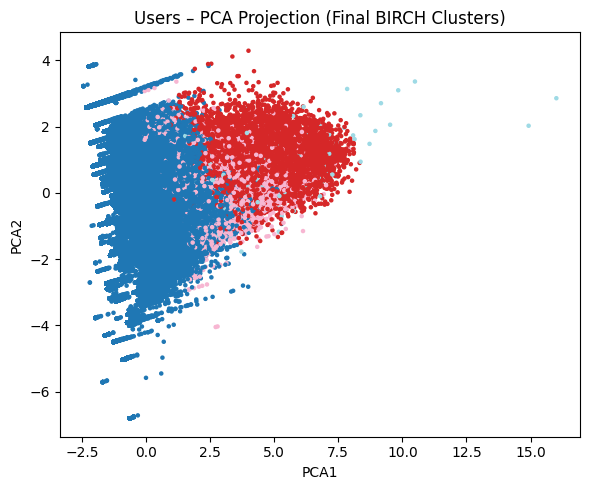

In [37]:
# PCA on user scaled matrix
pca_users = PCA(n_components=2)
users_pca_2d = pca_users.fit_transform(X_users_scaled)

# Add PCA coordinates to DataFrame
user_features_clean["PCA1_users"] = users_pca_2d[:,0]
user_features_clean["PCA2_users"] = users_pca_2d[:,1]

#PCA Plot - K-MEANS
plt.figure(figsize=(6,5))
plt.scatter(
    user_features_clean["PCA1_users"],
    user_features_clean["PCA2_users"],
    c=user_features_clean["cluster_kmeans"],
    cmap="tab20",
    s=5
)
plt.title("Users – PCA Projection (Final K-Means Clusters)")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.tight_layout()
plt.show()

#PCA Plot - MINIBATCH K-MEANS
plt.figure(figsize=(6,5))
plt.scatter(
    user_features_clean["PCA1_users"],
    user_features_clean["PCA2_users"],
    c=user_features_clean["cluster_minibatch"],
    cmap="tab20",
    s=5
)
plt.title("Users – PCA Projection (Final MiniBatch K-Means Clusters)")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.tight_layout()
plt.show()

#PCA Plot - BIRCH
plt.figure(figsize=(6,5))
plt.scatter(
    user_features_clean["PCA1_users"],
    user_features_clean["PCA2_users"],
    c=user_features_clean["cluster_birch"],
    cmap="tab20",
    s=5
)
plt.title("Users – PCA Projection (Final BIRCH Clusters)")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.tight_layout()
plt.show()

The PCA plots offer a qualitative view of separation and overlap among clusters. Differences between models (e.g., more compact vs more fragmented partitions) can become visible even in a 2D projection, although conclusions should be confirmed with quantitative metrics.


We compare the final clusterings using centroid-based Silhouette (separation proxy), cluster size balance (minimum size and dispersion of sizes), and the time required to compute the silhouette approximation. This helps select the most practical and interpretable user segmentation.

In addition, we derive a simple composite score by ranking models across these criteria: higher silhouette and larger minimum cluster size are rewarded, while higher cluster-size dispersion and longer computation time are penalized.
The resulting score provides an overall, practical ranking of the clustering models, allowing us to select the most interpretable and efficient user segmentation rather than relying on a single metric.


In [38]:
# 4.7 Select the best model by comparing the three clusterings

user_model_comparison = []

user_models = {
    "K-Means": user_features_clean["cluster_kmeans"].values,
    "MiniBatch K-Means": user_features_clean["cluster_minibatch"].values,
    "BIRCH": user_features_clean["cluster_birch"].values
}

for model_name, labels in user_models.items():

    labels = np.asarray(labels)

    t0 = time.time()
    cs = centroid_silhouette(X_users_scaled, labels)
    t_cs = time.time() - t0

    unique_labs, counts = np.unique(labels, return_counts=True)
    min_size = counts.min()
    max_size = counts.max()
    std_size = counts.std()

    user_model_comparison.append({
        "Model": model_name,
        "Centroid Silhouette": cs,
        "Min Cluster Size": min_size,
        "Max Cluster Size": max_size,
        "Std Cluster Size": std_size,
        "Time CS (sec)": round(t_cs, 3),
    })

user_model_comparison_df = pd.DataFrame(user_model_comparison)
df = user_model_comparison_df.assign(score=lambda d: d["Centroid Silhouette"].rank(pct=True) + d["Min Cluster Size"].rank(pct=True) - d["Std Cluster Size"].rank(pct=True) - d["Time CS (sec)"].rank(pct=True))
ranked = df.sort_values("score", ascending=False).reset_index(drop=True)
display(ranked[["Model","Centroid Silhouette","Min Cluster Size","Std Cluster Size","Time CS (sec)","score"]])


,Model,Centroid Silhouette,Min Cluster Size,Std Cluster Size,Time CS (sec),score
0,MiniBatch K-Means,0.436780,54538,48731.978343,4.801,0.666667
1,K-Means,0.434374,54988,53069.014290,5.837,-0.333333
2,BIRCH,0.480880,655,164498.510149,5.525,-0.333333


The table reports the final ranking of the user clustering models based on a composite score that jointly accounts for cluster separation (centroid silhouette), cluster-size balance, and computational efficiency.

Although BIRCH achieves the highest centroid silhouette value, it produces extremely imbalanced clusters, as indicated by the very small minimum cluster size and the large dispersion of cluster sizes.
This imbalance negatively affects interpretability and penalizes BIRCH in the overall ranking.

MiniBatch K-Means emerges as the best-performing model overall, offering a favorable trade-off between cluster quality, balanced cluster sizes, and execution time.

Standard K-Means shows comparable behavior but is slightly less efficient, resulting in a lower overall score.


# **5. MOVIE CLUSTERING (K-Means, MiniBatch K-Means, BIRCH)**

In this section, we cluster movies using three centroid-based methods (K-Means, MiniBatch K-Means, and BIRCH) on the standardized movie feature matrix. For each model, we explore a range of k values and evaluate candidate solutions using WCSS (Elbow method) for within-cluster compactness and centroid-based Silhouette for between-cluster separation. We then select a final global k via a simple consensus rule (majority vote across models; otherwise the k that maximizes the average silhouette). Finally, we fit the three models using the selected k, store cluster labels, visualize structure with a 2D PCA projection, and compare models in terms of silhouette, cluster-size balance, and computation time.


We start with K-Means and compute WCSS (via inertia) and centroid-based Silhouette across the same k range used for user clustering. Plotting both curves helps identify a compact, well-separated, and interpretable number of movie clusters.


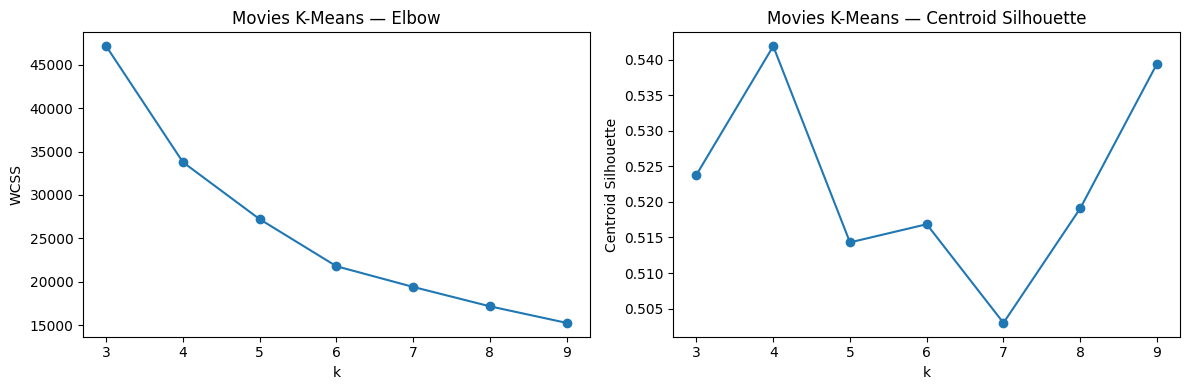

In [39]:
# 5.1 Movie K-Means — Elbow & Centroid Silhouette

kmeans_movies_wcss = []
kmeans_movies_cs = []

for k in k_values:
    model = KMeans(
        n_clusters=k,
        init="k-means++",
        n_init=10,
        random_state=42
    )
    labels = model.fit_predict(X_movies_scaled)

    kmeans_movies_wcss.append(model.inertia_)
    kmeans_movies_cs.append(centroid_silhouette(X_movies_scaled, labels))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(k_values, kmeans_movies_wcss, marker='o')
axes[0].set_title("Movies K-Means — Elbow")
axes[0].set_xlabel("k"); axes[0].set_ylabel("WCSS")

axes[1].plot(k_values, kmeans_movies_cs, marker='o')
axes[1].set_title("Movies K-Means — Centroid Silhouette")
axes[1].set_xlabel("k"); axes[1].set_ylabel("Centroid Silhouette")

plt.tight_layout()
plt.show()


The WCSS curve decreases with increasing k, while the silhouette curve typically peaks at a small-to-moderate k. Together, these plots indicate where additional clusters stop providing meaningful compactness/separation improvements.


We repeat the evaluation using MiniBatch K-Means, which is optimized for scalability. As with users, we compute WCSS using the generic function and centroid-based Silhouette for a consistent comparison across algorithms.


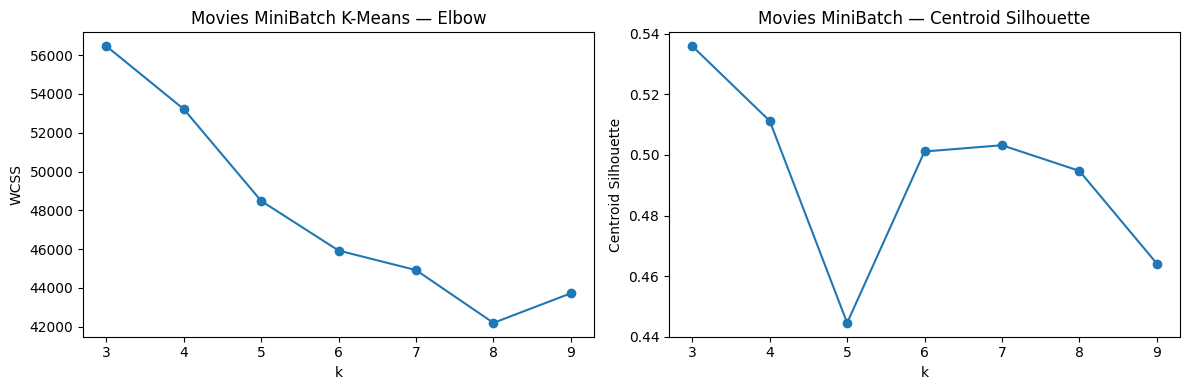

In [40]:
# 5.2 Movie MiniBatch K-Means — Elbow & Centroid Silhouette

minibatch_movies_wcss = []
minibatch_movies_cs = []

for k in k_values:
    model = MiniBatchKMeans(
        n_clusters=k,
        init="k-means++",
        batch_size=10_000,
        n_init=5,
        random_state=42
    )
    labels = model.fit_predict(X_movies_scaled)

    minibatch_movies_wcss.append(compute_wcss(X_movies_scaled, labels))
    minibatch_movies_cs.append(centroid_silhouette(X_movies_scaled, labels))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(k_values, minibatch_movies_wcss, marker='o')
axes[0].set_title("Movies MiniBatch K-Means — Elbow")
axes[0].set_xlabel("k"); axes[0].set_ylabel("WCSS")

axes[1].plot(k_values, minibatch_movies_cs, marker='o')
axes[1].set_title("Movies MiniBatch — Centroid Silhouette")
axes[1].set_xlabel("k"); axes[1].set_ylabel("Centroid Silhouette")

plt.tight_layout()
plt.show()


MiniBatch K-Means usually reproduces the main K-Means patterns while being more efficient on large datasets. A small k value that balances a visible elbow and a strong silhouette is typically preferred for interpretability.


We then evaluate BIRCH over the same k values. BIRCH can behave differently from K-Means variants due to its hierarchical summarization and sensitivity to parameters (e.g., threshold), so it is important to compare both separation and cluster-size balance later.


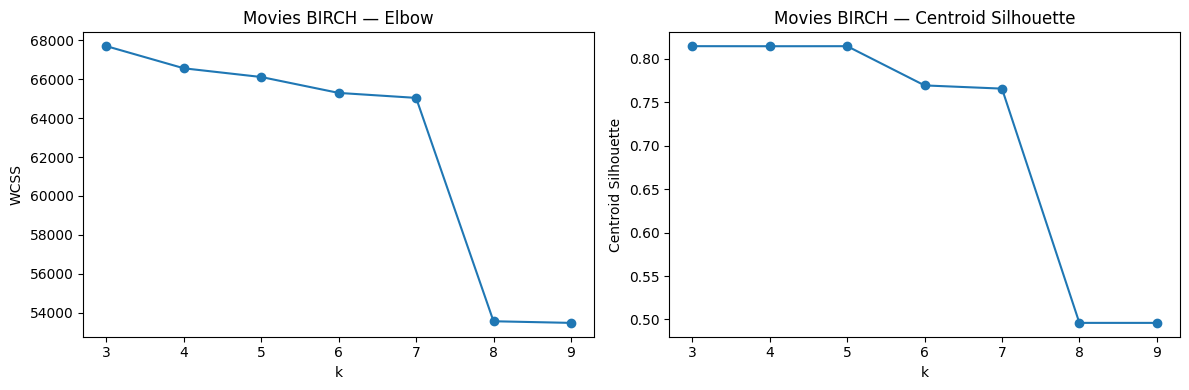

In [41]:
# 5.3 Movie BIRCH — Elbow & Centroid Silhouette

birch_movies_wcss = []
birch_movies_cs = []

for k in k_values:
    model = Birch(
        n_clusters=k,
        threshold=0.5,
        branching_factor=50
    )
    labels = model.fit_predict(X_movies_scaled)

    birch_movies_wcss.append(compute_wcss(X_movies_scaled, labels))
    birch_movies_cs.append(centroid_silhouette(X_movies_scaled, labels))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(k_values, birch_movies_wcss, marker='o')
axes[0].set_title("Movies BIRCH — Elbow")
axes[0].set_xlabel("k"); axes[0].set_ylabel("WCSS")

axes[1].plot(k_values, birch_movies_cs, marker='o')
axes[1].set_title("Movies BIRCH — Centroid Silhouette")
axes[1].set_xlabel("k"); axes[1].set_ylabel("Centroid Silhouette")

plt.tight_layout()
plt.show()


BIRCH may favor fewer clusters according to centroid-based Silhouette. However, even with strong separation, the resulting partition can be imbalanced, so the final decision also considers cluster-size balance.


We choose a final *k_best_movies* by first identifying the silhouette-optimal k for each model. If at least two models agree, we use that k as a consensus. Otherwise, we select the k that maximizes the average centroid-silhouette across all three methods.


In [42]:
# 5.4 Choose best k for movie clustering

# Best k according to Centroid Silhouette (per model)
best_k_kmeans_movies_cs = k_values[np.argmax(kmeans_movies_cs)]
best_k_birch_movies_cs = k_values[np.argmax(birch_movies_cs)]
best_k_minibatch_movies_cs  = k_values[np.argmax(minibatch_movies_cs)]

print("MOVIE clustering — Best k by Centroid Silhouette:")
print(f"K-Means: k = {best_k_kmeans_movies_cs}")
print(f"BIRCH: k = {best_k_birch_movies_cs}")
print(f"MiniBatch K-Means: k = {best_k_minibatch_movies_cs}")

# Try majority vote on Centroid Silhouette
movie_cs_ks = np.array([
    best_k_kmeans_movies_cs,
    best_k_birch_movies_cs,
    best_k_minibatch_movies_cs
])
values_m, counts_m = np.unique(movie_cs_ks, return_counts=True)

if counts_m.max() >= 2:
    # majority wins
    k_global_movies = int(values_m[counts_m.argmax()])
    print("\nMOVIE clustering → at least two models agree on k by centroid silhouette → using majority vote")
else:
    # fallback: maximize average centroid silhouette across models
    kmeans_movies_cs_arr = np.array(kmeans_movies_cs, dtype=float)
    birch_movies_cs_arr = np.array(birch_movies_cs, dtype=float)
    minibatch_movies_cs_arr = np.array(minibatch_movies_cs, dtype=float)

    avg_cs_movies = (kmeans_movies_cs_arr + birch_movies_cs_arr + minibatch_movies_cs_arr) / 3.0
    best_idx_global_movies = int(np.argmax(avg_cs_movies))
    k_global_movies = int(k_values[best_idx_global_movies])

    print("\nMOVIE clustering → no agreement between models on centroid-silhouette-best k.")
    print("Using k that maximizes the AVERAGE centroid silhouette across all movie models")

print("\n\nFINAL GLOBAL k for MOVIES:")
print(f"Chosen k_best_movies = {k_global_movies}")

k_best_movies = k_global_movies


MOVIE clustering — Best k by Centroid Silhouette:
K-Means:           k = 4
BIRCH:             k = 3
MiniBatch K-Means: k = 3

MOVIE clustering → at least two models agree on k by centroid silhouette → using majority vote


FINAL GLOBAL k for MOVIES:
Chosen k_best_movies = 3


This produces a single *k_best_movies* that is used consistently across K-Means, MiniBatch K-Means, and BIRCH, enabling a fair and transparent comparison of the final segmentations.


Using *k_best_movies*, we fit the three clustering algorithms on the standardized movie feature matrix and store the cluster labels in *movie_features*. This prepares the dataset for PCA visualization and for downstream cluster profiling.


In [43]:
# 5.5 Final movie clusters with K-Means, MiniBatch, BIRCH

# Final K-Means on movies
kmeans_movies_final = KMeans(
    n_clusters=k_best_movies,
    init="k-means++",
    n_init=10,
    random_state=42
)
movie_features["cluster_kmeans_movies"] = kmeans_movies_final.fit_predict(X_movies_scaled)

# Final MiniBatch K-Means on movies
minibatch_movies_final = MiniBatchKMeans(
    n_clusters=k_best_movies,
    init="k-means++",
    batch_size=10_000,
    n_init=5,
    random_state=42
)
movie_features["cluster_minibatch_movies"] = minibatch_movies_final.fit_predict(X_movies_scaled)

# Final BIRCH on movies
birch_movies_final = Birch(
    n_clusters=k_best_movies,
    threshold=0.5,
    branching_factor=50
)
movie_features["cluster_birch_movies"] = birch_movies_final.fit_predict(X_movies_scaled)

movie_features.head()

,movie_id,total_ratings,avg_rating,std_rating,min_rating,max_rating,unique_users,cluster_kmeans_movies,cluster_minibatch_movies,cluster_birch_movies
0,1,548.0,3.744526,1.073389,1.0,5.0,548.0,1,2,2
1,2,146.0,3.547945,1.281606,1.0,5.0,146.0,1,2,2
2,3,2013.0,3.639841,0.978873,1.0,5.0,2013.0,1,2,2
3,4,142.0,2.739437,1.302913,1.0,5.0,142.0,1,2,2
4,5,1140.0,3.919298,1.292436,1.0,5.0,1140.0,1,2,2


At this point, each movie has three cluster assignments, allowing direct comparison of how different algorithms segment the same item feature space.


To visually inspect the cluster structure, we project the standardized movie features into 2D using PCA. This provides an interpretable view of cluster separation in a reduced space, while clustering itself remains computed in the full feature space.


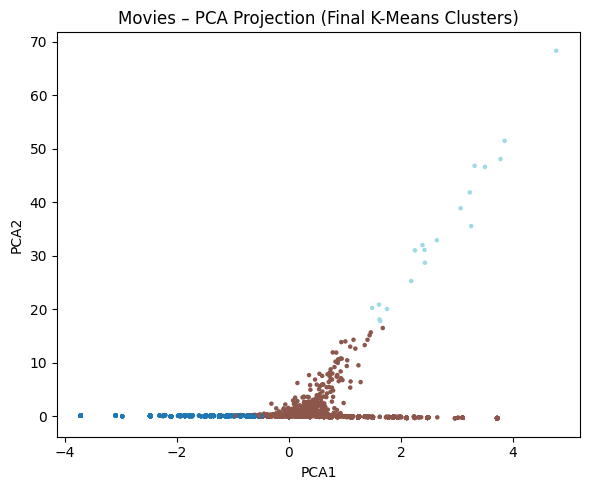

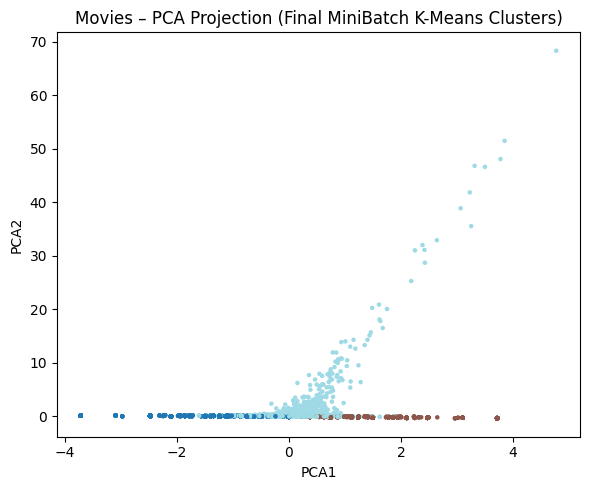

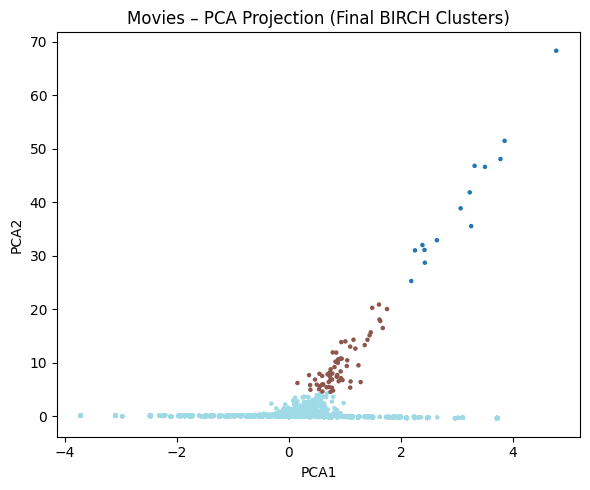

In [44]:
# PCA on movie scaled matrix
pca_movies = PCA(n_components=2)
movies_pca_2d = pca_movies.fit_transform(X_movies_scaled)

# Add PCA coordinates to DataFrame
movie_features["PCA1_movies"] = movies_pca_2d[:,0]
movie_features["PCA2_movies"] = movies_pca_2d[:,1]

#PCA Plot - K-MEANS
plt.figure(figsize=(6,5))
plt.scatter(
    movie_features["PCA1_movies"],
    movie_features["PCA2_movies"],
    c=movie_features["cluster_kmeans_movies"],
    cmap="tab20",
    s=5
)
plt.title("Movies – PCA Projection (Final K-Means Clusters)")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.tight_layout()
plt.show()

#PCA Plot - MINIBATCH K-MEANS
plt.figure(figsize=(6,5))
plt.scatter(
    movie_features["PCA1_movies"],
    movie_features["PCA2_movies"],
    c=movie_features["cluster_minibatch_movies"],
    cmap="tab20",
    s=5
)
plt.title("Movies – PCA Projection (Final MiniBatch K-Means Clusters)")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.tight_layout()
plt.show()


#PCA Plot - BIRCH
plt.figure(figsize=(6,5))
plt.scatter(
    movie_features["PCA1_movies"],
    movie_features["PCA2_movies"],
    c=movie_features["cluster_birch_movies"],
    cmap="tab20",
    s=5
)
plt.title("Movies – PCA Projection (Final BIRCH Clusters)")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.tight_layout()
plt.show()


The PCA plots provide a qualitative check for cluster separation and overlap. Differences between the three algorithms may become visible in the 2D projection, but final conclusions should be based on the quantitative comparison that follows.


We compare the final movie clustering solutions using centroid-based Silhouette as a proxy for separation quality, cluster-size balance (minimum size and dispersion) to assess segmentation stability, and the time required to compute the silhouette approximation to account for computational efficiency.

In addition, a composite ranking score is derived by jointly considering these criteria, allowing us to select a movie segmentation that is not only well separated, but also interpretable and practically usable.


In [45]:
# # 5.6 Select the best model by comparing the three clusterings

import time

movie_model_comparison = []

movie_models = {
    "K-Means": movie_features["cluster_kmeans_movies"].values,
    "MiniBatch K-Means": movie_features["cluster_minibatch_movies"].values,
    "BIRCH": movie_features["cluster_birch_movies"].values
}

for model_name, labels in movie_models.items():

    labels = np.asarray(labels)

    t0 = time.time()
    cs = centroid_silhouette(X_movies_scaled, labels)
    t_cs = time.time() - t0

    unique_labs, counts = np.unique(labels, return_counts=True)
    min_size = counts.min()
    max_size = counts.max()
    std_size = counts.std()

    movie_model_comparison.append({
        "Model": model_name,
        "Centroid Silhouette": cs,
        "Min Cluster Size": min_size,
        "Max Cluster Size": max_size,
        "Std Cluster Size": std_size,
        "Time CS (sec)": round(t_cs, 3),
    })

movie_model_comparison_df = pd.DataFrame(movie_model_comparison)
df = movie_model_comparison_df.assign(score=lambda d: d["Centroid Silhouette"].rank(pct=True) + d["Min Cluster Size"].rank(pct=True) - d["Std Cluster Size"].rank(pct=True) - d["Time CS (sec)"].rank(pct=True))
ranked = df.sort_values("score", ascending=False).reset_index(drop=True)
display(ranked[["Model","Centroid Silhouette","Min Cluster Size","Std Cluster Size","Time CS (sec)","score"]])


,Model,Centroid Silhouette,Min Cluster Size,Std Cluster Size,Time CS (sec),score
0,MiniBatch K-Means,0.535953,3689,1375.021293,0.277,6.666667e-01
1,BIRCH,0.814303,14,7493.474065,0.176,-5.551115e-17
2,K-Means,0.523838,19,4253.666445,0.334,-6.666667e-01


The table compares the final movie clustering models using a composite score that combines centroid-based silhouette (as a proxy for separation quality), cluster-size balance, and computational efficiency.

Although BIRCH achieves the highest centroid silhouette, it generates highly unbalanced clusters, as reflected by very small minimum cluster sizes and large dispersion.
This imbalance reduces the practical usability of the segmentation and leads to a lower overall ranking.

MiniBatch K-Means provides the best overall trade-off, producing more balanced movie clusters while maintaining good separation quality and low computational cost.

Standard K-Means performs similarly but shows slightly less stable partitions in this setting.


# **6. CLUSTER INTERPRETATION (using MiniBatch K-Means)**

In this section, we interpret clusters by focusing on the MiniBatch K-Means solutions, selected as the most practical and balanced option among the tested methods. We combine user-cluster assignments and movie-cluster assignments with historical ratings to estimate cluster-to-cluster affinity (which movie clusters each user cluster tends to like). In parallel, we compute a global movie quality score (based on rating and popularity) and aggregate it at the movie-cluster level. Finally, we blend affinity and quality into a single preference score and visualize the results as a user-cluster × movie-cluster preference matrix, which supports behavioral profiling and recommendation logic.


We define the cluster-label columns used throughout this interpretation step. MiniBatch K-Means is used consistently for both users and movies to keep the segmentation framework coherent.


In [46]:
# 6.1 Define cluster column names
# We use MiniBatch K-Means as it has the best performance among the three models

user_cluster_col = "cluster_minibatch"
movie_cluster_col = "cluster_minibatch_movies"


From this point onward, *user_cluster_col* and *movie_cluster_col* identify the reference segmentation used to compute affinities and preference patterns.


We build two compact tables: one mapping each user to a user cluster, and one mapping each movie to a movie cluster plus the statistics needed to build a quality measure (*avg_rating*, *total_ratings*). These are the inputs for merging clusters with historical interactions.


In [47]:
# 6.2 Select relevant columns from user and movie tables

user_clusters = user_statistics_clean[["customer_id", user_cluster_col]].copy()

movies_for_rec = movie_features[[
    "movie_id",
    movie_cluster_col,
    "avg_rating",
    "total_ratings"
]].copy()

print("User clusters shape:", user_clusters.shape)
print("\nMovies for recommendation shape:", movies_for_rec.shape, "\n")

print(movies_for_rec.head())


User clusters shape: (434429, 2)

Movies for recommendation shape: (16013, 4) 

   movie_id  cluster_minibatch_movies  avg_rating  total_ratings
0         1                         2    3.744526          548.0
1         2                         2    3.547945          146.0
2         3                         2    3.639841         2013.0
3         4                         2    2.739437          142.0
4         5                         2    3.919298         1140.0


The printed shapes confirm the number of user and movie cluster assignments available for interpretation. The preview ensures the movie-level fields required for scoring are present and correctly named.


We define a global quality score for each movie that balances perceived quality and popularity. *avg_rating* captures how much the movie is liked, while *total_ratings* (log-transformed) captures how stable and representative the average rating is. Both components are normalized to ensure comparable scales before weighting.


In [48]:
# 6.3 Build a global QUALITY SCORE for each movie

# A good movie = high average rating + reasonable popularity
movies_for_rec["avg_rating"] = movies_for_rec["avg_rating"].fillna(
    movies_for_rec["avg_rating"].median()
)
movies_for_rec["total_ratings"] = movies_for_rec["total_ratings"].fillna(0)

# Normalize avg_rating to [0, 1]
avg_min = movies_for_rec["avg_rating"].min()
avg_max = movies_for_rec["avg_rating"].max()
movies_for_rec["avg_rating_norm"] = (
    (movies_for_rec["avg_rating"] - avg_min) /
    (avg_max - avg_min + 1e-8)
)

# Popularity via log(1 + total_ratings), normalized to [0, 1]
movies_for_rec["log_popularity"] = np.log1p(movies_for_rec["total_ratings"])

pop_min = movies_for_rec["log_popularity"].min()
pop_max = movies_for_rec["log_popularity"].max()
movies_for_rec["popularity_norm"] = (
    (movies_for_rec["log_popularity"] - pop_min) /
    (pop_max - pop_min + 1e-8)
)

# Final movie quality score (weights can be tuned)
movies_for_rec["quality_score"] = (
    0.7 * movies_for_rec["avg_rating_norm"] +
    0.3 * movies_for_rec["popularity_norm"]
)

print("Movies with quality_score:")
movies_for_rec.head()


Movies with quality_score:


,movie_id,cluster_minibatch_movies,avg_rating,total_ratings,avg_rating_norm,log_popularity,popularity_norm,quality_score
0,1,2,3.744526,548.0,0.624088,6.308098,0.493780,0.584995
1,2,2,3.547945,146.0,0.591324,4.990433,0.377904,0.527298
2,3,2,3.639841,2013.0,0.606640,7.607878,0.608083,0.607073
3,4,2,2.739437,142.0,0.456573,4.962845,0.375478,0.432244
4,5,2,3.919298,1140.0,0.653216,7.039660,0.558114,0.624686


This score prioritizes rating quality while still rewarding movies with sufficient audience size, reducing the impact of extreme averages driven by very few ratings. The resulting *quality_score* is later aggregated at the movie-cluster level.


We merge the cleaned ratings with user clusters and movie clusters so that each interaction is enriched with (*user_cluster*, *movie_cluster*) and the movie’s *quality_score*. This creates the base table for estimating affinities between user types and movie types.


In [49]:
# 6.4 Merge ratings with user clusters and movie clusters

# This connects:
#  customer_id → user_cluster
#  movie_id  → movie_cluster + quality_score
# Based on this we can see, for each pair (user_cluster, movie_cluster),
# which ratings users have actually given.

# Add user cluster to ratings
ratings_with_users = viewer_ratings_clean.merge(
    user_clusters, on="customer_id", how="inner"
)

# Add movie cluster and movie stats to ratings
ratings_with_clusters = ratings_with_users.merge(
    movies_for_rec[["movie_id", movie_cluster_col, "quality_score"]],
    on="movie_id",
    how="inner"
)

print("Ratings with user + movie clusters shape:", ratings_with_clusters.shape, "\n")
ratings_with_clusters.head()


Ratings with user + movie clusters shape: (3311389, 8) 



,movie_id,customer_id,rating,date,anomalous_date,cluster_minibatch,cluster_minibatch_movies,quality_score
0,17,1481737,3.0,2005-10-09,NaN,1,2,0.554407
1,9236,1448424,5.0,2005-11-15,NaN,3,2,0.589176
2,9330,674346,3.0,2005-04-29,NaN,2,2,0.706497
3,4570,1304045,4.0,2005-09-19,NaN,2,2,0.635003
4,9320,1036533,5.0,2004-08-05,NaN,2,2,0.659323


The resulting dataset contains only interactions that can be linked to both a user cluster and a movie cluster, ensuring that affinity statistics are computed on consistent and fully defined records.


We compute, for each pair (*user_cluster*, *movie_cluster*), the mean rating and the number of interactions. This provides the raw ingredients to estimate affinity: how much a given user type tends to appreciate a given movie type, and how strong the evidence is.


In [50]:
# 6.5.1 Aggregate ratings by (user_cluster, movie_cluster)
# user_cluster → movie_cluster affinity

# For each pair (u, m) we compute:
#  mean_rating: how much users in cluster u rate movies in cluster m
#  count_interactions: how many such ratings exist

cluster_pair_stats = (
    ratings_with_clusters
    .groupby([user_cluster_col, movie_cluster_col])
    .agg(
        mean_rating=("rating", "mean"),
        count_interactions=("rating", "size")
    )
    .reset_index()
)

print("Cluster pair stats (raw):")
cluster_pair_stats.head()


Cluster pair stats (raw):


,cluster_minibatch,cluster_minibatch_movies,mean_rating,count_interactions
0,0,0,1.887102,6590
1,0,1,2.992826,697
2,0,2,2.390684,70008
3,1,0,3.420904,354
4,1,1,4.556382,4975


*mean_rating* captures the average appreciation, while *count_interactions* captures statistical support. Both are needed because high average ratings with very few interactions are less reliable.


We combine average rating and interaction volume into a single affinity weight, using *log1p(count_interactions)* to dampen extreme popularity effects. We then normalize the affinity signal to [0, 1] to make it directly comparable with the normalized movie-cluster quality component.


In [51]:
# 6.5.2 Cluster-level affinity weight: users in cluster u like movies in cluster m

cluster_pair_stats["cluster_weight"] = (
    cluster_pair_stats["mean_rating"] *
    np.log1p(cluster_pair_stats["count_interactions"])
)

# Normalize affinity to [0, 1]
w_min = cluster_pair_stats["cluster_weight"].min()
w_max = cluster_pair_stats["cluster_weight"].max()
cluster_pair_stats["cluster_weight_norm"] = (
    (cluster_pair_stats["cluster_weight"] - w_min) /
    (w_max - w_min + 1e-8)
)

print("Cluster pair stats with normalized affinity:")
cluster_pair_stats.head()


Cluster pair stats with normalized affinity:


,cluster_minibatch,cluster_minibatch_movies,mean_rating,count_interactions,cluster_weight,cluster_weight_norm
0,0,0,1.887102,6590,16.594154,0.088672
1,0,1,2.992826,697,19.597683,0.159551
2,0,2,2.390684,70008,26.671376,0.326481
3,1,0,3.420904,354,20.087951,0.171121
4,1,1,4.556382,4975,38.785662,0.612361


This produces an affinity proxy that increases when users both rate a cluster highly and interact with it frequently, while remaining robust to scale effects through the logarithmic term and normalization.


Independently of user behavior, we estimate how strong each movie cluster is in general by averaging the movie-level *quality_score* within each movie cluster. We normalize this score to [0, 1] and merge it back into the cluster-pair table.


In [52]:
# 6.6 Aggregate movie QUALITY by movie_cluster
# → average “quality_score” for each movie cluster

# This answers: "Independently of who watches them, how good are movies in cluster m?"

movie_cluster_quality = (
    movies_for_rec
    .groupby(movie_cluster_col)["quality_score"]
    .mean()
    .reset_index()
    .rename(columns={"quality_score": "cluster_quality"})
)

# Normalize cluster_quality to [0, 1] for comparability with affinity
cq_min = movie_cluster_quality["cluster_quality"].min()
cq_max = movie_cluster_quality["cluster_quality"].max()
movie_cluster_quality["cluster_quality_norm"] = (
    (movie_cluster_quality["cluster_quality"] - cq_min) /
    (cq_max - cq_min + 1e-8)
)

# Drop duplicate column if it exists
if "cluster_quality_norm" in cluster_pair_stats.columns:
    cluster_pair_stats = cluster_pair_stats.drop(columns=["cluster_quality_norm"])

# Now safe merge
cluster_pair_stats = cluster_pair_stats.merge(
    movie_cluster_quality[[movie_cluster_col, "cluster_quality_norm"]],
    on=movie_cluster_col,
    how="left"
)
print("Movie cluster quality:")
movie_cluster_quality.head()


Movie cluster quality:


,cluster_minibatch_movies,cluster_quality,cluster_quality_norm
0,0,0.229366,0.000000
1,1,0.513603,1.000000
2,2,0.401356,0.605095


*cluster_quality_norm* captures the “global attractiveness” of each movie cluster, separating the concept of what users tend to watch/rate from how strong the items are on average.


We combine the two normalized signals into a single *preference_score*. The weights (alpha, gamma) control the trade-off between learned audience affinity and general cluster quality.


In [53]:
# 6.7 Combine AFFINITY (user_cluster → movie_cluster) and QUALITY (movie_cluster) into a single preference score

alpha = 0.6  # weight for affinity (how much this user type likes this movie type)
gamma = 0.4  # weight for quality (how good movies in this cluster are in general)

cluster_pair_stats["preference_score"] = (
    alpha * cluster_pair_stats["cluster_weight_norm"] +
    gamma * cluster_pair_stats["cluster_quality_norm"]
)

print("Cluster pair stats with final preference_score:")
cluster_pair_stats.head()


Cluster pair stats with final preference_score:


,cluster_minibatch,cluster_minibatch_movies,mean_rating,count_interactions,cluster_weight,cluster_weight_norm,cluster_quality_norm,preference_score
0,0,0,1.887102,6590,16.594154,0.088672,0.000000,0.053203
1,0,1,2.992826,697,19.597683,0.159551,1.000000,0.495731
2,0,2,2.390684,70008,26.671376,0.326481,0.605095,0.437926
3,1,0,3.420904,354,20.087951,0.171121,0.000000,0.102673
4,1,1,4.556382,4975,38.785662,0.612361,1.000000,0.767416


The resulting score summarizes which movie clusters are most promising for each user cluster, balancing historical preferences with overall content quality.


We reshape the cluster-pair scores into a matrix where rows represent user clusters and columns represent movie clusters. This provides an interpretable heatmap-like view that supports cluster profiling and recommendation logic.


In [54]:
# 6.8 Create the final Ux → Fy preference matrix

# preference_score(u, m) ~ how attractive movie-cluster m is for user-cluster u,
# Before removing already-seen movies at individual level.

preference_matrix = cluster_pair_stats.pivot(
    index=user_cluster_col,
    columns=movie_cluster_col,
    values="preference_score"
).fillna(0)

# Make a "pretty" version with nice labels
pref_pretty = preference_matrix.copy()
pref_pretty = pref_pretty.round(2)

# Rename index (user clusters) as U0, U1, U2, ...
pref_pretty.index = [f"U{int(i)}" for i in pref_pretty.index]

# Rename columns (movie clusters) as F0, F1, F2, ...
pref_pretty.columns = [f"F{int(j)}" for j in pref_pretty.columns]

print("\nUser clusters → Moovie clusters PREFERENCE MATRIX")
display(pref_pretty)


User clusters → Moovie clusters PREFERENCE MATRIX


,F0,F1,F2
U0,0.05,0.50,0.44
U1,0.10,0.77,0.84
U2,0.08,0.59,0.79
U3,0.00,0.56,0.72


**F0 — Low-Attraction / Marginal Content**: movies with low overall appeal and limited engagement.

**F1 — Mainstream Popular Titles**: widely consumed movies with moderate-to-high popularity and solid average ratings.

**F2 — Top-Quality / High-Engagement Movies**: movies combining high ratings and strong audience engagement, representing the highest-quality content segment.


The matrix reports a preference score for each (user cluster, movie cluster) pair, combining observed affinity (ratings and interaction strength) with cluster-level quality. Overall, **F2 (Top-Quality / High-Engagement Movies)** is the most consistently preferred movie cluster across user groups (highest for U1–U3 and second-highest for U0), while **F0 (Low-Attraction / Marginal Content)** is systematically the least preferred, with near-zero scores for all clusters.


**U0 — Selective Mainstream Explorers:**
Preferences concentrate on **F1 (Mainstream Popular Titles)** (0.50) and **F2 (Top-Quality Movies)** (0.44), with very low alignment with **F0** (0.05), indicating a focused profile that strongly deprioritizes marginal content.

**U1 — High-Engagement Quality Seekers:** This cluster shows the strongest overall preference intensity, with **F2** (0.84) and **F1** (0.77) clearly dominant and **F0** (0.10) remaining weak.

**U2 — Casual Quality-Oriented Viewers:** A similar ranking to U1 but with lower intensity, preferring F2 (0.79) over F1 (0.59), and showing minimal interest in F0 (0.08).

**U3 — Highly Selective Critics:** The most restrictive pattern toward **F0** (0.00), while still exhibiting clear preferences for **F2** (0.72) and **F1** (0.56).



**Takeaway:** User clusters mainly differ in preference strength and in how sharply they exclude **F0 (Low-Attraction Content)**, while **F2 (Top-Quality / High-Engagement Movies)** emerges as the most broadly attractive movie cluster under the current scoring framework.

# **7. RECOMMENDATION: TOP-10 MOVIES PER SINGLE USER**

In this section, we build a simple, transparent recommendation step to generate Top-N movie suggestions for an individual user. The recommender uses the user’s assigned cluster (MiniBatch K-Means) to capture broad preference patterns and scores candidate movies using two components: (1) cluster-level affinity between the user cluster and the movie cluster, and (2) a movie-level quality score. Recommendations exclude items the user has already rated, and the remaining candidates are ranked by the final score to return the Top-10 list.


To make recommendation efficient, we precompute dictionaries for constant-time lookup of: normalized cluster affinity, per-movie quality, each movie’s cluster assignment, and the set of movies already seen by each user. This avoids repeated merges and groupby operations during scoring.


In [55]:
# 7.1 Dictionaries for fast lookup


# Create dictionary for cluster–movie affinity weights
cluster_weight_dict = {
    (row[user_cluster_col], row[movie_cluster_col]): row["cluster_weight_norm"]
    for _, row in cluster_pair_stats.iterrows()
}

# Create dictionary mapping each movie to its quality score
quality_dict = dict(
    zip(movies_for_rec["movie_id"], movies_for_rec["quality_score"])
)

# Create dictionary mapping each movie to its assigned cluster
movie_cluster_dict = dict(
    zip(movies_for_rec["movie_id"], movies_for_rec[movie_cluster_col])
)

# Build dictionary storing the set of movies seen by each user
user_seen_movies = (
    viewer_ratings_clean.groupby("customer_id")["movie_id"]
    .apply(set)
    .to_dict()
)

print("Number of users with at least one seen movie:", len(user_seen_movies))


Number of users with at least one seen movie: 428152


The reported number confirms how many users have at least one interaction in the cleaned ratings table, which defines the population for which “already seen” filtering can be applied.


We define a scoring function that combines affinity (how much the user’s cluster tends to like the movie’s cluster) and quality (how strong the movie is globally). The weights (alpha, gamma) control the relative influence of these two components.


In [56]:
# 7.2 Scoring function for a single movie

def score_single(user_cluster, movie_cluster, movie_id,
                 alpha=0.6, gamma=0.4, default_cluster_weight=0.0):

    # Score for a movie given:
    #  the user's cluster (user_cluster)
    #  the movie's cluster (movie_cluster)
    #  the movie_id to fetch its quality_score

    # Components:
    #  cluster_weight_dict[(user_cluster, movie_cluster)] → affinity
    #  quality_dict[movie_id] → quality

    cw = cluster_weight_dict.get((user_cluster, movie_cluster),
                                 default_cluster_weight)
    q  = quality_dict.get(movie_id, 0.0)
    return alpha * cw + gamma * q


This scoring design is intentionally simple and interpretable: it recommends movies that belong to clusters historically appreciated by similar users, while also prioritizing items with higher quality estimates.


We implement a function that produces recommendations for a target user by: (1) finding the user’s cluster, (2) removing already-seen movies, (3) scoring all remaining candidates, and (4) returning the Top-N ranked items.


In [57]:
# 7.3 Recommend Top-N movies for a given user

def recommend_top_n_movies(target_user_id, n=10):
    # Identify user cluster
    row = user_statistics_clean.loc[user_statistics_clean["customer_id"] == target_user_id]
    if row.empty:
        raise ValueError(f"User {target_user_id} not found in 'user_statistics_clean'.")

    user_cluster = int(row[user_cluster_col].iloc[0])

    # Movies already seen
    seen = user_seen_movies.get(target_user_id, set())

    # Candidate movies = all movies not seen
    candidates = movies_for_rec[~movies_for_rec["movie_id"].isin(seen)].copy()

    # Compute scores
    scores = []
    for mid, mcluster in zip(candidates["movie_id"],
                             candidates[movie_cluster_col]):
        s = score_single(user_cluster, int(mcluster), int(mid))
        scores.append(s)

    candidates["score"] = scores

    # Sort and pick top N
    top_n = candidates.sort_values("score", ascending=False).head(n)

    return top_n


This function produces a ranked list of candidate movies for the selected user. The final list is personalized at the cluster level (via affinity) and refined at the item level (via quality), while ensuring that previously seen titles are not recommended again.


During development we considered two alternative ways of demonstrating the system. Both produce the same recommendations, but differ in how the results are presented and how interactive the notebook is. We start with the first one:


In [58]:
#7.4 Example usage (with titles) (Option-1)
# All valid user IDs that can be used in recommendation
valid_user_ids = np.sort(user_statistics_clean["customer_id"].unique())

print(f"Number of all valid user IDs: {len(valid_user_ids)}\n")

# Print the full list of valid IDs
print("List of all valid user IDs:")
print(valid_user_ids)
print("\n")

valid_user_ids_df = pd.DataFrame({"customer_id": valid_user_ids})
display(valid_user_ids_df)

# CHANGE THIS MANUALLY TO TEST DIFFERENT USERS
target_user_id = 42

if target_user_id not in valid_user_ids:
    raise ValueError("This user_id is not present in the dataset. "
                     "Choose one from valid_user_ids.")

top10 = recommend_top_n_movies(target_user_id, n=10)

recommended_titles = top10.merge(
    movies_clean[["movie_id", "title"]],
    on="movie_id",
    how="left"
)

print(f"\nTop 10 recommended movies for user {target_user_id}:")
display(recommended_titles[["movie_id", "title", "score"]])


Number of all valid user IDs: 434429

List of all valid user IDs:
[      6       7       8 ... 2983248 2983918 2992620]




,customer_id
0,6
1,7
2,8
3,10
4,25
...,...
434424,2977063
434425,2977806
434426,2983248
434427,2983918



Top 10 recommended movies for user 42:


,movie_id,title,score
0,4640,Rain Man,0.908803
1,175,Reservoir Dogs,0.899965
2,4633,Gandhi,0.898476
3,9254,The Goonies,0.898149
4,223,Chappelle's Show: Season 1,0.895689
5,9426,Platoon,0.895514
6,4656,Erin Brockovich,0.894973
7,4577,Steel Magnolias,0.894849
8,13402,The Count of Monte Cristo,0.893306
9,9433,Fiddler on the Roof,0.888866


**Option 1 — manual user selection**

In this version, all valid user IDs are listed and the analyst may manually select one of them to generate a personalised Top-10 recommendation list.

Pros: This approach is fully interactive and shows that the recommender can be reused for any user in the dataset.

Cons: The dataset contains 434,429 valid users, meaning that listing all available user IDs inevitably produces a very large and noisy output. Moreover, due to notebook rendering limits, the output can display only a subset of the IDs (approximately 20,000), preventing full visualization of the complete list.

**Option 2 — report-style demonstration (selected users)**

To improve readability, we implemented a more compact version that does not print the full list of IDs.
Instead, we show: the first 10 users in the dataset, the last 10 users, and 10 randomly sampled users

For each of these users, we display the Top-10 recommended movies.

In [59]:
# 7.4 Example usage (with titles) (Option-2)

# All valid user IDs that can be used in recommendation
valid_user_ids = np.sort(user_statistics_clean["customer_id"].unique())
print(f"Number of valid user IDs: {len(valid_user_ids)}")

# Show a compact preview instead of printing the full list (~hundreds of thousands)
print("\nExample valid user IDs:")
print("  First 10:", valid_user_ids[:10])
print("  Last 10: ", valid_user_ids[-10:])

# Optional: random sample (useful to pick a test user)
np.random.seed(42)
print("  Random 10:", np.random.choice(valid_user_ids, size=10, replace=False))

# CHANGE THIS MANUALLY TO TEST DIFFERENT USERS
target_user_id = 42

if target_user_id not in valid_user_ids:
    raise ValueError(
        f"User {target_user_id} is not present in the dataset. "
        "Choose an ID from the valid_user_ids set."
    )

top10 = recommend_top_n_movies(target_user_id, n=10)

recommended_titles = top10.merge(
    movies_clean[["movie_id", "title"]],
    on="movie_id",
    how="left"
)

print(f"\nTop 10 recommended movies per user {target_user_id}:")
display(recommended_titles[["movie_id", "title", "score"]])

Number of valid user IDs: 434429

Example valid user IDs:
  First 10: [ 6  7  8 10 25 33 42 59 79 83]
  Last 10:  [2877797 2908384 2926846 2934361 2969702 2977063 2977806 2983248 2983918
 2992620]
  Random 10: [2392226 1494074  374259  100873 1988320 1228999 1364654 2508247  554995
 2080345]

Top 10 recommended movies per user 42:


,movie_id,title,score
0,4640,Rain Man,0.908803
1,175,Reservoir Dogs,0.899965
2,4633,Gandhi,0.898476
3,9254,The Goonies,0.898149
4,223,Chappelle's Show: Season 1,0.895689
5,9426,Platoon,0.895514
6,4656,Erin Brockovich,0.894973
7,4577,Steel Magnolias,0.894849
8,13402,The Count of Monte Cristo,0.893306
9,9433,Fiddler on the Roof,0.888866


This presentation keeps the notebook concise while still demonstrating that the recommender system works across different user profiles. The interactive version (Option 1) is kept in the notebook for completeness, but Option 2 is used as the primary output because it is clearer and more interpretable in a report-style submission.